# Imperial College Final Year Project
## Anomaly   detection   in   road   traffic   videosurveillance
#### Student: Eren Kopuz
Project Supervisor: Dr Christos-Savvas Bouganis
Second Marker: Professor Peter Cheung



This document provides the code used to run the test in the project 'Anomaly   detection   in   road   traffic   videosurveillance' for the Imperial College London Electrical Engineering Department Final Year Project.

The following sources have been used in the preparation of this code:



[1]  “Opencv:Opticalflow.”[Online].Available:https://docs.opencv.org/3.3.1/d7/d8b/tutorialpylucaskanade.htm

[2]  “Buildingautoencodersinkeras.”[Online].Available:https://blog.keras.io/building-autoencoders-in-keras.html48


[3]  A. Filos, “eigenfaces/src/visualize.py.” [Online]. Available: https://github.com/filangel/eigenfaces/blob/master/src/visualize.py

[4]  “Confusion matrix.” [Online]. Available: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


[5]  V.  Valkov,   “Credit  card  fraud  detection  using  autoencoders  in  keras  —tensorflow   for   hackers   (part   vii),”   -06-11T17:28:06.780Z   2017.   [Online].Available:  https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

[6]  A.  Ponnusamy,  “Yolo  object  detection  with  opencv  and  python.”  [Online].Available:  arunponnusamy.com

[7]  “Simple Multivariate Gaussian Anomaly Detection.” [Online]. Available: https://kaggle.com/clemensmzr/simple-multivariate-gaussian-anomaly-detection. [Accessed: 17-Jun-2019]

# Load Dependencies

In [1]:
# [6]

import cv2
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from scipy.spatial import distance
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, roc_curve, auc, confusion_matrix
from inspect import signature
import itertools

from keras.models import Model, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras import backend as K

import time
import skimage.measure

from math import ceil


%matplotlib inline





Using TensorFlow backend.


# Functions

In [2]:




def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers


def draw_prediction(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


def get_yolo_output(image):

    Width = image.shape[1]
    Height = image.shape[0]
    scale = 0.00392

    blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

    net.setInput(blob)

    outs = net.forward(get_output_layers(net))


    class_ids = []
    confidences = []
    boxes = []
    conf_threshold = 0.5
    nms_threshold = 0.4


    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])


    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    
    boxes_nms = []
    class_ids_nms = []
    confidences_nms = []
    
    
    for i in indices:
        i = i[0]
        boxes_nms.append(boxes[i])
        class_ids_nms.append(class_ids[i])
        confidences_nms.append(confidences[i])
    
    return boxes_nms, class_ids_nms, confidences_nms


def print_on_image(image, boxes_nms, class_ids_nms, confidences_nms):

    #cv2.polylines(image,swalk_pts,True,(0,255,255),thickness=3)
    #cv2.polylines(image,lane_pts,True,(255,0,255),thickness=3)
    
    
    for i, box in enumerate(boxes_nms):
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]
        draw_prediction(image, class_ids_nms[i], confidences_nms[i], round(x), round(y), round(x+w), round(y+h))
        

        
def create_grid_image(boxes_nms, class_ids_nms, confidences_nms, grid_scaling_factor, grid_background):
    
    
    grid_vehicles   = np.zeros((grid_y_size,grid_x_size), dtype = np.int8)
    grid_person     = np.zeros((grid_y_size,grid_x_size), dtype = np.int8)
    grid_bicycle    = np.zeros((grid_y_size,grid_x_size), dtype = np.int8)
    
    for i, box in enumerate(boxes_nms):

        x = round(box[0])
        y = round(box[1])
        w = box[2]
        h = box[3]

        x_plus_w = round(x+w)
        y_plus_h = round(y+h)


        x = round(x/grid_scaling_factor)
        y = round(y/grid_scaling_factor)
        x_plus_w = round(x_plus_w/grid_scaling_factor)
        y_plus_h = round(y_plus_h/grid_scaling_factor)
        
        if class_ids_nms[i] in [2, 3, 5, 6, 7]:  # Motorized vehicles [car, motorcycle, bus, train, truck]
            
            cv2.rectangle(grid_vehicles, (x,y), (x_plus_w,y_plus_h), vehicle_w, -1)


        elif class_ids_nms[i]==0:  # Person
            
            cv2.rectangle(grid_person, (x,y), (x_plus_w,y_plus_h), person_w, -1) 
            
        elif class_ids_nms[i]==1:  # Bicycle
            
            cv2.rectangle(grid_bicycle, (x,y), (x_plus_w,y_plus_h), bicycle_w, -1)
            
        else:
            continue
    
    grid_overflow = np.zeros((grid_y_size,grid_x_size), dtype = np.int16)    
    #grid_overflow = np.array([grid_background,grid_vehicles,grid_person,grid_bicycle])
    grid_overflow = np.array([grid_vehicles,grid_person,grid_bicycle])
    grid_overflow = grid_overflow.sum(axis=0)
    grid_overflow[grid_overflow>127] = 127
    grid_overflow[grid_overflow<-128] = -128
    grid = np.array(grid_overflow,dtype=np.int8)

    return grid
       

    
def create_grid(boxes_nms, class_ids_nms, confidences_nms, grid_scaling_factor, grid_background,
               vehicles=False,
               persons=False,
               bicycles=False):
    
    options = [vehicles, persons, bicycles]
    num_channels = options.count(True)
    
    grid = np.zeros((num_channels,grid_y_size,grid_x_size), dtype = bool)
    
    
    grid_vehicles   = np.zeros((grid_y_size,grid_x_size), dtype = bool)
    grid_person     = np.zeros((grid_y_size,grid_x_size), dtype = bool)
    grid_bicycle    = np.zeros((grid_y_size,grid_x_size), dtype = bool)
    
    present_val = 1
    
    for i, box in enumerate(boxes_nms):

        x = round(box[0])
        y = round(box[1])
        w = box[2]
        h = box[3]

        x_plus_w = round(x+w)
        y_plus_h = round(y+h)


        x = round(x/grid_scaling_factor)
        y = round(y/grid_scaling_factor)
        x_plus_w = round(x_plus_w/grid_scaling_factor)
        y_plus_h = round(y_plus_h/grid_scaling_factor)
        
        
        if class_ids_nms[i] in [2, 3, 5, 6, 7]:  # Motorized vehicles [car, motorcycle, bus, train, truck]
            
            grid_vehicles[y:y_plus_h+1,x:x_plus_w+1] = present_val

        elif class_ids_nms[i]==0:  # Person
            
            grid_person[y:y_plus_h+1,x:x_plus_w+1] = present_val
            
        elif class_ids_nms[i]==1:  # Bicycle
            
            grid_bicycle[y:y_plus_h+1,x:x_plus_w+1] = present_val
            
        else:
            continue


    j = 0
    if vehicles:
        grid[j] = grid_vehicles
        j = j+1
    if persons:
        grid[j] = grid_person
        j = j+1
    if bicycles:
        grid[j] = grid_bicycle
        j = j+1
    
    return grid
       



# Spatial and Time Scaling Coefficients
* "seconds" represents the time intervals in seconds at which samples will be taken from the video.    
* "grid_scaling_factor" represents the factor by which the grid will be shrunk.

In [3]:
seconds = 0.25
grid_scaling_factor = 32

# Background Areas

In [4]:

########### Background Areas #############

#lanes

lane_pts = []
lane_pts_1 = np.array([[540,0],[483,303],[314,555],[0,915],[0,1080],[625,1080],[708,719],[745,544],[763,362],[687,154],[791,310],[822,396],[835,582],[806,861],[779,1080],[1114,1080],[1060,664],[988,418],[924,317],[662,0]], np.int32)
lane_pts_1 = lane_pts_1.reshape((-1,1,2))

lane_pts_2 = np.array([[1920,600],[1832,660],[1760,773],[1692,907],[1660,1080],[1140,1080],[1245,893],[1418,691],[1590,569],[1782,480],[1920,421]], np.int32)
lane_pts_2 = lane_pts_2.reshape((-1,1,2))

lane_pts.append(lane_pts_1)
lane_pts.append(lane_pts_2)


lane_pts_grid = []

for pts in lane_pts:
    grid_pts = np.divide(pts,grid_scaling_factor)
    np.round_(grid_pts)
    grid_pts = np.array(grid_pts,dtype=np.int32)
    lane_pts_grid.append(grid_pts)



#sidewalks

swalk_pts = []
swalk_pts_1 = np.array([[454,0],[540,0],[514,143],[448,149],[383,306],[483,303],[314,555],[0,915],[0,425],[179,356]], np.int32)
swalk_pts_1 = swalk_pts_1.reshape((-1,1,2))

swalk_pts_2 = np.array([[986,265],[1173,264],[1268,319],[1484,291],[1600,296],[1920,224],[1920,281],[1280,529],[1151,500]], np.int32)
swalk_pts_2 = swalk_pts_2.reshape((-1,1,2))

swalk_pts_3 = np.array([[1920,600],[1920,1080],[1660,1080],[1692,907],[1760,773],[1832,660]], np.int32)
swalk_pts_3 = swalk_pts_3.reshape((-1,1,2))


swalk_pts.append(swalk_pts_1)
swalk_pts.append(swalk_pts_2)
swalk_pts.append(swalk_pts_3)


swalk_pts_grid = []

for pts in swalk_pts:
    grid_pts = np.divide(pts,grid_scaling_factor)
    np.round_(grid_pts)
    grid_pts = np.array(grid_pts,dtype=np.int32)
    swalk_pts_grid.append(grid_pts)
    


#out of bounds (oob) areas


#median spaces



## Grid Weights

In [5]:

########### Grid Weights #############


lane_w = 32
swalk_w = -32
oob_w = -127
med_sp_w = 0


vehicle_w = 64
person_w = -64
bicycle_w = 32

# obj_w = 




## Load Model

In [6]:

##################################################################### 

classes = None

with open('yolov3.txt', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

GREYSCALE = np.random.uniform(0, 255, size=(len(classes)))

net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')


#image = cv2.imread('dog.jpg')

#####################################################################




## Load Video

In [7]:





videofile = 'videos/FYP_Traffic_Footage_Embankment.mp4'

cap = cv2.VideoCapture(videofile)

assert cap.isOpened(), 'Cannot capture source'

frameId = int(round(cap.get(1))) #current frame number, rounded b/c sometimes you get frame intervals which aren't integers...this adds a little imprecision but is likely good enough
success,image = cap.read()



fps = int(round(cap.get(cv2.CAP_PROP_FPS))) # Gets the frames per second
num_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) # Gets the total number of frames

print('Number of Frames: ', num_frames)




frame_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH) # Gets the frame width
frame_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) # Gets the frame width

grid_x_size = int(round(frame_width/grid_scaling_factor))
grid_y_size = int(round(frame_height/grid_scaling_factor))


multiplier = int(round(fps * seconds))
num_scenes = int(round(num_frames/(fps * seconds)))

print('Number of Scenes: ', num_scenes)


grids_v       = np.zeros((num_scenes,1,grid_y_size,grid_x_size), dtype = bool)
grids_p       = np.zeros((num_scenes,1,grid_y_size,grid_x_size), dtype = bool)
grids_vp      = np.zeros((num_scenes,2,grid_y_size,grid_x_size), dtype = bool)
grids_vpb     = np.zeros((num_scenes,3,grid_y_size,grid_x_size), dtype = bool)


frameIds    = np.zeros((num_scenes), dtype = np.int32)
time_sec_count = np.zeros((num_scenes), dtype = np.int32)


#################### Initiate Process ################

#################### Create Background Grid ################

grid_background = np.zeros((grid_y_size,grid_x_size), dtype = np.int8)

# Mark background
cv2.fillPoly(grid_background,lane_pts_grid,lane_w)
cv2.fillPoly(grid_background,swalk_pts_grid,swalk_w)

print('FPS: ', fps)



Number of Frames:  98382.0
Number of Scenes:  16397
FPS:  24


## Process Video

In [8]:


############################################################

i = 0

while success:

    if frameId % multiplier == 0:
        

        
#############################################################

        
        boxes_nms, class_ids_nms, confidences_nms = get_yolo_output(image)
        
        grid = create_grid(boxes_nms, class_ids_nms, confidences_nms, grid_scaling_factor,grid_background,
                           vehicles = True,
                           persons = True,
                           bicycles = True)
        
        second_count = round(frameId/fps)
        
        
        
        grids_v[i] = grid[0]
        grids_p[i] = grid[1]
        grids_vp[i] = grid[:2]
        grids_vpb[i] = grid
        
        
        
        frameIds[i] = frameId
        time_sec_count[i] = second_count
        
        
        
        
        
        
        if frameId % (40*multiplier) == 0:
            
            print ('Time processed = ', int(second_count/60), ' mins ', second_count%60, ' seconds')
            
            
            grid_rep = np.array(grid[1],dtype=np.uint8)
            grid_rep = np.multiply(grid_rep,255)
            cv2.imwrite("output/representations/rep%d.jpg" % frameId, grid_rep)
        
            grid_image = create_grid_image(boxes_nms, class_ids_nms, confidences_nms, grid_scaling_factor,grid_background)
            grid_image_16_bit = np.array(grid_image,dtype=np.int16)
            grid_image_16_bit = np.add(grid_image_16_bit,128)
            grid_image_unsigned = np.array(grid_image_16_bit,dtype=np.uint8)
            cv2.imwrite("output/grids/grid%d.jpg" % frameId, grid_image_unsigned)

            print_on_image(image, boxes_nms, class_ids_nms, confidences_nms)

            cv2.imwrite("output/frames/frame%d.jpg" % frameId, image)
        
        
        i= i+1
        
        #print ('One image done')
        
        
    frameId = int(round(cap.get(1))) #current frame number, rounded b/c sometimes you get frame intervals which aren't integers...this adds a little imprecision but is likely good enough
    success, image = cap.read()


        #plt.figure(figsize = (15, 15))
        #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    
#cv2.imwrite("object-detection.jpg", image)
#cv2.destroyAllWindows()

print (i)

cap.release()



print ("Complete")





Time processed =  0  mins  0  seconds
Time processed =  0  mins  10  seconds
Time processed =  0  mins  20  seconds
Time processed =  0  mins  30  seconds
Time processed =  0  mins  40  seconds
Time processed =  0  mins  50  seconds
Time processed =  1  mins  0  seconds
Time processed =  1  mins  10  seconds
Time processed =  1  mins  20  seconds
Time processed =  1  mins  30  seconds
Time processed =  1  mins  40  seconds
Time processed =  1  mins  50  seconds
Time processed =  2  mins  0  seconds
Time processed =  2  mins  10  seconds
Time processed =  2  mins  20  seconds
Time processed =  2  mins  30  seconds
Time processed =  2  mins  40  seconds
Time processed =  2  mins  50  seconds
Time processed =  3  mins  0  seconds
Time processed =  3  mins  10  seconds
Time processed =  3  mins  20  seconds
Time processed =  3  mins  30  seconds
Time processed =  3  mins  40  seconds
Time processed =  3  mins  50  seconds
Time processed =  4  mins  0  seconds
Time processed =  4  mins  10 

Time processed =  34  mins  42  seconds
Time processed =  34  mins  52  seconds
Time processed =  35  mins  2  seconds
Time processed =  35  mins  12  seconds
Time processed =  35  mins  22  seconds
Time processed =  35  mins  32  seconds
Time processed =  35  mins  42  seconds
Time processed =  35  mins  52  seconds
Time processed =  36  mins  2  seconds
Time processed =  36  mins  12  seconds
Time processed =  36  mins  22  seconds
Time processed =  36  mins  32  seconds
Time processed =  36  mins  42  seconds
Time processed =  36  mins  52  seconds
Time processed =  37  mins  2  seconds
Time processed =  37  mins  12  seconds
Time processed =  37  mins  22  seconds
Time processed =  37  mins  32  seconds
Time processed =  37  mins  42  seconds
Time processed =  37  mins  52  seconds
Time processed =  38  mins  2  seconds
Time processed =  38  mins  12  seconds
Time processed =  38  mins  22  seconds
Time processed =  38  mins  32  seconds
Time processed =  38  mins  42  seconds
Time

In [9]:
np.save("grid_arrays/grids_v.npy", grids_v)
np.save("grid_arrays/grids_p.npy", grids_p)
np.save("grid_arrays/grids_vp.npy", grids_vp)
np.save("grid_arrays/grids_vpb.npy", grids_vpb)

np.save("grid_arrays/frameIds.npy", frameIds)
np.save("grid_arrays/time_sec_count.npy", time_sec_count)

# Optical Flow

In [81]:
optflow_procc_scale=16
averaging_scale = 2
maxing_scale = 2

res_enlarg_scale = 2

grids_flow_max     = np.zeros((num_scenes,res_enlarg_scale*grid_y_size,res_enlarg_scale*grid_x_size,2), dtype = np.float16)
grids_flow_avg     = np.zeros((num_scenes,res_enlarg_scale*grid_y_size,res_enlarg_scale*grid_x_size,2), dtype = np.float16)
print(grids_flow_max.shape)
print(grids_flow_max.dtype)

(16397, 68, 120, 2)
float16


In [82]:
cap = cv2.VideoCapture(videofile)

assert cap.isOpened(), 'Cannot capture source'

frameId = int(round(cap.get(1))) #current frame number, rounded b/c sometimes you get frame intervals which aren't integers...this adds a little imprecision but is likely good enough
success,image1 = cap.read()
image1 = cv2.resize(image1,(optflow_procc_scale*grid_x_size,optflow_procc_scale*grid_y_size))
print(image1.shape)

success,image2 = cap.read()
image2 = cv2.resize(image2,(optflow_procc_scale*grid_x_size,optflow_procc_scale*grid_y_size))

prvs = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(image1)
hsv[...,1] = 255

print(hsv.shape)




(544, 960, 3)
(544, 960, 3)


In [83]:

cv2.imwrite("resized_image.jpg", image1)

True

In [84]:
start = time.time()

############################################################

i = 0

while success:
    
    success,image3 = cap.read()
    if success:
        image3 = cv2.resize(image3,(optflow_procc_scale*grid_x_size,optflow_procc_scale*grid_y_size))
    

        if frameId % multiplier == 0:
            
            nxt = cv2.cvtColor(image3,cv2.COLOR_BGR2GRAY)
            prvs = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
            flow = cv2.calcOpticalFlowFarneback(prvs,nxt, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            
            #print('flow shape: ', flow.shape)
            #print('flow type: ', flow.dtype)
            
            
            
            
                  
            second_count = round(frameId/fps)
        
            flow_resize = skimage.measure.block_reduce(flow,        (averaging_scale,averaging_scale,1), np.mean)
            flow_resize = skimage.measure.block_reduce(flow_resize, (maxing_scale,maxing_scale,1), np.max)
            
            flow_maxed = skimage.measure.block_reduce(flow_resize, (int(round(optflow_procc_scale/averaging_scale/maxing_scale/res_enlarg_scale)),int(round(optflow_procc_scale/averaging_scale/maxing_scale/res_enlarg_scale)),1), np.max)
            flow_avged = skimage.measure.block_reduce(flow_resize, (int(round(optflow_procc_scale/averaging_scale/maxing_scale/res_enlarg_scale)),int(round(optflow_procc_scale/averaging_scale/maxing_scale/res_enlarg_scale)),1), np.mean)


            #print('flow_maxed shape: ', flow_maxed.shape)
            
            grids_flow_max[i] = flow_maxed
            grids_flow_avg[i] = flow_avged
            
            #print('array type: ', grids_flow_max.dtype)










            if frameId % (40*multiplier) == 0:

                print ('Time processed = ', int(second_count/60), ' mins ', second_count%60, ' seconds')

                end = time.time()
                print('Time elapsed : ', end-start, ' s')
                start = time.time()

                mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
                hsv[...,0] = ang*180/np.pi/2
                hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
                bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)


                cv2.imwrite("output/optical_flow/flow%d.jpg" % frameId, bgr)

                end_write = time.time()
                print('Time for image write : ', end_write-start, ' s')


            i= i+1

            #print ('One image done')
        
        
    frameId = int(round(cap.get(1))) #current frame number, rounded b/c sometimes you get frame intervals which aren't integers...this adds a little imprecision but is likely good enough
    
    image1 = image2
    image2 = image3


        #plt.figure(figsize = (15, 15))
        #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    
#cv2.imwrite("object-detection.jpg", image)
#cv2.destroyAllWindows()

print (i)

cap.release()



print ("Complete")






Time processed =  0  mins  0  seconds
Time elapsed :  0.21234583854675293  s
Time for image write :  0.014770984649658203  s
Time processed =  0  mins  10  seconds
Time elapsed :  9.355029821395874  s
Time for image write :  0.015583038330078125  s
Time processed =  0  mins  20  seconds
Time elapsed :  9.091700077056885  s
Time for image write :  0.019397974014282227  s
Time processed =  0  mins  30  seconds
Time elapsed :  9.173808813095093  s
Time for image write :  0.016443967819213867  s
Time processed =  0  mins  40  seconds
Time elapsed :  9.187047958374023  s
Time for image write :  0.01519012451171875  s
Time processed =  0  mins  50  seconds
Time elapsed :  9.340467929840088  s
Time for image write :  0.01513981819152832  s
Time processed =  1  mins  0  seconds
Time elapsed :  9.252874851226807  s
Time for image write :  0.015382051467895508  s
Time processed =  1  mins  10  seconds
Time elapsed :  9.242669105529785  s
Time for image write :  0.015042781829833984  s
Time proce

Time processed =  11  mins  10  seconds
Time elapsed :  9.613186120986938  s
Time for image write :  0.015516996383666992  s
Time processed =  11  mins  20  seconds
Time elapsed :  9.932229995727539  s
Time for image write :  0.014590024948120117  s
Time processed =  11  mins  30  seconds
Time elapsed :  9.982796907424927  s
Time for image write :  0.01613306999206543  s
Time processed =  11  mins  40  seconds
Time elapsed :  9.60128903388977  s
Time for image write :  0.01636981964111328  s
Time processed =  11  mins  50  seconds
Time elapsed :  9.60188102722168  s
Time for image write :  0.019569873809814453  s
Time processed =  12  mins  0  seconds
Time elapsed :  9.59406590461731  s
Time for image write :  0.015302896499633789  s
Time processed =  12  mins  10  seconds
Time elapsed :  9.768518924713135  s
Time for image write :  0.015745162963867188  s
Time processed =  12  mins  20  seconds
Time elapsed :  9.906139135360718  s
Time for image write :  0.01576685905456543  s
Time pr

Time processed =  22  mins  10  seconds
Time elapsed :  10.222318172454834  s
Time for image write :  0.015439748764038086  s
Time processed =  22  mins  20  seconds
Time elapsed :  10.054674863815308  s
Time for image write :  0.015791893005371094  s
Time processed =  22  mins  30  seconds
Time elapsed :  10.211808681488037  s
Time for image write :  0.01572704315185547  s
Time processed =  22  mins  40  seconds
Time elapsed :  10.082293033599854  s
Time for image write :  0.015429019927978516  s
Time processed =  22  mins  50  seconds
Time elapsed :  10.043667078018188  s
Time for image write :  0.013983964920043945  s
Time processed =  23  mins  0  seconds
Time elapsed :  10.046626091003418  s
Time for image write :  0.014664888381958008  s
Time processed =  23  mins  10  seconds
Time elapsed :  10.421203851699829  s
Time for image write :  0.014765024185180664  s
Time processed =  23  mins  20  seconds
Time elapsed :  10.159994125366211  s
Time for image write :  0.0143358707427978

Time processed =  33  mins  10  seconds
Time elapsed :  10.218370914459229  s
Time for image write :  0.01624608039855957  s
Time processed =  33  mins  20  seconds
Time elapsed :  9.993664979934692  s
Time for image write :  0.015334844589233398  s
Time processed =  33  mins  30  seconds
Time elapsed :  10.221323013305664  s
Time for image write :  0.016065120697021484  s
Time processed =  33  mins  40  seconds
Time elapsed :  10.228409051895142  s
Time for image write :  0.015039920806884766  s
Time processed =  33  mins  50  seconds
Time elapsed :  9.94347095489502  s
Time for image write :  0.01529383659362793  s
Time processed =  34  mins  0  seconds
Time elapsed :  10.063046932220459  s
Time for image write :  0.016662120819091797  s
Time processed =  34  mins  10  seconds
Time elapsed :  10.193588018417358  s
Time for image write :  0.016232013702392578  s
Time processed =  34  mins  20  seconds
Time elapsed :  10.070133924484253  s
Time for image write :  0.015110969543457031  

Time processed =  44  mins  10  seconds
Time elapsed :  9.891884088516235  s
Time for image write :  0.01621389389038086  s
Time processed =  44  mins  20  seconds
Time elapsed :  9.683765888214111  s
Time for image write :  0.015906095504760742  s
Time processed =  44  mins  30  seconds
Time elapsed :  9.628156900405884  s
Time for image write :  0.01648998260498047  s
Time processed =  44  mins  40  seconds
Time elapsed :  9.619141817092896  s
Time for image write :  0.020071029663085938  s
Time processed =  44  mins  50  seconds
Time elapsed :  9.72446322441101  s
Time for image write :  0.015008926391601562  s
Time processed =  45  mins  0  seconds
Time elapsed :  9.786865234375  s
Time for image write :  0.015081167221069336  s
Time processed =  45  mins  10  seconds
Time elapsed :  10.188777208328247  s
Time for image write :  0.015551090240478516  s
Time processed =  45  mins  20  seconds
Time elapsed :  10.110916137695312  s
Time for image write :  0.016104936599731445  s
Time 

Time processed =  55  mins  10  seconds
Time elapsed :  10.254815340042114  s
Time for image write :  0.01665806770324707  s
Time processed =  55  mins  20  seconds
Time elapsed :  10.283332824707031  s
Time for image write :  0.016861915588378906  s
Time processed =  55  mins  30  seconds
Time elapsed :  10.130747079849243  s
Time for image write :  0.015169620513916016  s
Time processed =  55  mins  40  seconds
Time elapsed :  10.40176796913147  s
Time for image write :  0.016447067260742188  s
Time processed =  55  mins  50  seconds
Time elapsed :  10.319720029830933  s
Time for image write :  0.03966879844665527  s
Time processed =  56  mins  0  seconds
Time elapsed :  10.525672197341919  s
Time for image write :  0.015124320983886719  s
Time processed =  56  mins  10  seconds
Time elapsed :  10.18528413772583  s
Time for image write :  0.014295578002929688  s
Time processed =  56  mins  20  seconds
Time elapsed :  10.721472978591919  s
Time for image write :  0.020608901977539062 

Time processed =  66  mins  10  seconds
Time elapsed :  9.720619201660156  s
Time for image write :  0.014299154281616211  s
Time processed =  66  mins  20  seconds
Time elapsed :  9.669826030731201  s
Time for image write :  0.014861822128295898  s
Time processed =  66  mins  30  seconds
Time elapsed :  9.803874015808105  s
Time for image write :  0.014561891555786133  s
Time processed =  66  mins  40  seconds
Time elapsed :  9.677913904190063  s
Time for image write :  0.015256166458129883  s
Time processed =  66  mins  50  seconds
Time elapsed :  9.671487092971802  s
Time for image write :  0.01466679573059082  s
Time processed =  67  mins  0  seconds
Time elapsed :  9.738292932510376  s
Time for image write :  0.017513036727905273  s
Time processed =  67  mins  10  seconds
Time elapsed :  9.666337013244629  s
Time for image write :  0.014961004257202148  s
Time processed =  67  mins  20  seconds
Time elapsed :  9.687368154525757  s
Time for image write :  0.01495504379272461  s
Tim

In [85]:
np.save("grid_arrays/grids_flow_max.npy", grids_flow_max)
np.save("grid_arrays/grids_flow_avg.npy", grids_flow_avg)

In [132]:
print(grids_flow[grids_flow==0].shape)
print((16414-16397)*34*60*2)

(69360,)
69360


In [26]:
grids_flow = np.load("grid_arrays/grids_flow.npy")

In [110]:



grids_test     = np.arange((optflow_procc_scale*34*optflow_procc_scale*60*2), dtype = np.float32).reshape((optflow_procc_scale*34,optflow_procc_scale*60,2))

print(grids_test.shape)

grids_test = skimage.measure.block_reduce(grids_test, (averaging_scale,averaging_scale,1), np.mean)
grids_test = skimage.measure.block_reduce(grids_test, (int(round(optflow_procc_scale/averaging_scale)),int(round(optflow_procc_scale/averaging_scale)),1), np.max)

print(grids_test.shape)




(544, 960, 2)
(34, 60, 2)


In [216]:
print(grids.shape)

(16414, 34, 60, 2)


In [245]:
hsv = np.zeros((grids.shape[1],grids.shape[2],3), dtype=np.int8)
print(hsv.shape)
hsv[...,1] = 255

for flow, frameId in zip(grids, frameIds):
    print(flow.shape)
    
    if frameId % (40*multiplier) == 0:
        
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
        
        print(hsv.shape)
        
        color_map = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        


        cv2.imwrite("output/optical_flow_compressed/flow%d.jpg" % frameId, color_map)



(34, 60, 3)
(34, 60, 2)
(34, 60, 3)


error: OpenCV(3.4.2) /opt/concourse/worker/volumes/live/9523d527-1b9e-48e0-7ed0-a36adde286f0/volume/opencv-suite_1535558719691/work/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'


# Ground Truth

In [8]:
ground_truth_df = pd.read_csv('ground_truth/embankment_ground_csv.csv', sep=';', header=0)

print(ground_truth_df)



    anomaly_class  start_time_s  end_time_s
0               1           942         952
1               1          1038        1048
2               1          1223        1230
3               1          1408        1474
4               1          1526        1530
5               1          1634        1638
6               1          1639        1679
7               1          1707        1717
8               1          1878        1883
9               1          1884        1887
10              1          1904        1908
11              1          1927        1932
12              1          2075        2088
13              1          2112        2118
14              1          2222        2288
15              1          2414        2419
16              2          2185        2193
17              2          2549        2552
18              2          2585        2592
19              2          3204        3214
20              2          4102        4103
21              3           348 

In [9]:
ground_truth    = np.zeros((num_scenes), dtype = np.int8)



ground_truth_all_frames    = np.zeros((int(round(num_frames))), dtype = np.int8)

In [10]:

for index, row in ground_truth_df.iterrows():
    start_frameId = int(round(row['start_time_s']*fps))
    end_frameId = int(round(row['end_time_s']*fps))
    
    ground_truth_all_frames[start_frameId:end_frameId] = row['anomaly_class']
    
    start_frameId_mult = int(round(row['start_time_s']*fps/multiplier))
    end_frameId_mult = int(round(row['end_time_s']*fps/multiplier))
    
    ground_truth[start_frameId_mult:end_frameId_mult] = 1
    
print('Anomaly Distribution within Total Frames')
print('U-turns: \t\t\t\t', (ground_truth_all_frames==1).sum(), ' frames, ',100*((ground_truth_all_frames==1).sum())/ground_truth_all_frames.shape[0], '%')
print('Dangerous pedestrian crossing: \t\t', (ground_truth_all_frames==2).sum(), ' frames, ',100*((ground_truth_all_frames==2).sum())/ground_truth_all_frames.shape[0], '%')
print('Bicycle wrong direction: \t\t', (ground_truth_all_frames==3).sum(), ' frames, ',100*((ground_truth_all_frames==3).sum())/ground_truth_all_frames.shape[0], '%')
print('Emergency vehicle unusual behaviour: \t', (ground_truth_all_frames==4).sum(), ' frames, ',100*((ground_truth_all_frames==4).sum())/ground_truth_all_frames.shape[0], '%')

print('\n\n')

print('Anomaly Distribution within Used Frames')
print('Anomalies: \t\t\t\t', (ground_truth==1).sum(), ' scenes, ',100*((ground_truth==1).sum())/ground_truth.shape[0], '%')



Anomaly Distribution within Total Frames
U-turns: 				 6192  frames,  6.29383423797036 %
Dangerous pedestrian crossing: 		 672  frames,  0.6830517777642252 %
Bicycle wrong direction: 		 360  frames,  0.3659205952308349 %
Emergency vehicle unusual behaviour: 	 120  frames,  0.12197353174361164 %



Anomaly Distribution within Used Frames
Anomalies: 				 1224  scenes,  7.464780142709032 %


In [89]:
for frameId, anomaly in zip(frameIds,ground_truth):
    if anomaly==1:
        cap.set(1, frameId)
        success, frame = cap.read()
        if success:
            cv2.imwrite("output/anomalous_frames/frame%d.jpg" % frameId, frame)



In [77]:
np.save("grid_arrays/ground_truth.npy", ground_truth)

In [90]:
grids_v = np.load("grid_arrays/grids_v.npy")
grids_p = np.load("grid_arrays/grids_p.npy")
grids_vp = np.load("grid_arrays/grids_vp.npy")
grids_vpb = np.load("grid_arrays/grids_vpb.npy")




In [11]:
frameIds = np.load("grid_arrays/frameIds.npy")
time_sec_count = np.load("grid_arrays/time_sec_count.npy")

In [ ]:
ground_truth = np.load("grid_arrays/ground_truth.npy")

In [12]:


clip_range = 2  # in seconds

clip_size = int(round(clip_range/seconds))

print(ground_truth.shape)
print(num_scenes)

num_clips = int(ceil(ground_truth.shape[0]/clip_size))
print(num_clips)

y_gt    = np.zeros((num_clips), dtype = np.int8)


for i, gt in enumerate(y_gt):
    if 1 in ground_truth[clip_size*i:clip_size*(i+1)]:
        y_gt[i] = 1


j = 0
for y in y_gt:
    if y ==1:
        j = j+1

print(j)
print(100*j/num_clips)


(16397,)
16397
2050
162
7.902439024390244


In [14]:
print(grids.shape)

NameError: name 'grids' is not defined

# Learning Algorithms on Grids

In [13]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    [3][4]

    """
    

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.yticks(tick_marks, target_names, rotation=90, size=20)
        plt.xticks(tick_marks, target_names, size=20)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     size=20,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     size=20,
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [14]:


def calc_metrics(y_true, y_score, display_graphs=False):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    print('ROC_AUC: {0:0.2f}'.format(
      roc_auc))
    
    if display_graphs==True:
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='firebrick',
                 lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        
    average_precision = average_precision_score(y_true, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
    
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    if display_graphs==True:
        step_kwargs = ({'step': 'post'}
                       if 'step' in signature(plt.fill_between).parameters
                       else {})
        plt.step(recall, precision, color='firebrick', alpha=0.2,
                 where='post')
        plt.fill_between(recall, precision, alpha=0.2, color='firebrick', **step_kwargs)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
                  average_precision))
        plt.show()
    
    F1_best = 0
    F1_new = 0
    threshold_best = 0
    prec_f1 = 0
    rec_f1 = 0
    
    for prec, rec, threshold in zip(precision, recall, thresholds):
        F1_new = 2*prec*rec/(prec + rec)
        if F1_new > F1_best:
            F1_best = F1_new
            threshold_best = threshold
            prec_f1 = prec
            rec_f1 = rec
            
    print('Best F1 score of ', F1_best, ' achieved at threshold of ', threshold_best)
    print('Corresponding vales are: Precision ', prec_f1, ' Recall: ', rec_f1)
    
    if display_graphs==True:
        y_hat = [1 if a > threshold_best else 0 for a in y_score]
        cfn_matrix = confusion_matrix(y_true, y_hat)

        class_names = np.arange(0,2)

        plt.figure()

        plot_confusion_matrix(cm           = cfn_matrix, 
                              normalize    = False,
                              target_names = class_names,
                              title        = "Confusion Matrix")

        plt.show()
        
    return roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall
    

In [15]:
grid_type = 'flow_max'

if grid_type == 'v':
    grids = np.load("grid_arrays/grids_v.npy")
if grid_type == 'p':
    grids = np.load("grid_arrays/grids_p.npy")
if grid_type == 'vp':
    grids = np.load("grid_arrays/grids_vp.npy")
if grid_type == 'flow_avg':
    grids = np.load("grid_arrays/grids_flow_avg.npy")
if grid_type == 'flow_max':
    grids = np.load("grid_arrays/grids_flow_max.npy")

In [20]:
# !! Remove if running code from beginning, inserted to compensate for miscalculation of array size in original run

grids = grids[:16397]



In [17]:
frameIds = frameIds[:16397]
time_sec_count = time_sec_count[:16397]

In [18]:
# Ensure all arrays are of the same length

print(len(grids))
print(len(frameIds))
print(len(time_sec_count))
print(len(ground_truth))

16397
16397
16397
16397


## Convert to Magnitude - Angle Form
!!! For use only with optical flow grids

In [99]:
grids_flow_ang     = np.zeros((grids.shape[0],grids.shape[1],grids.shape[2]), dtype = np.float16)
grids_flow_mag     = np.zeros((grids.shape[0],grids.shape[1],grids.shape[2]), dtype = np.float16)
print(grids_flow_ang.shape)

for i, grid in enumerate(grids):
    for j, row in enumerate(grid):
        for k, loc in enumerate(row):
            mag = np.sqrt(loc[0]**2+loc[1]**2)
            ang = np.arctan2(loc[1],loc[0])
            #print(ang)
            grids_flow_mag[i,j,k] = mag
            grids_flow_ang[i,j,k] = ang
    print('Element ', i, ' done.')


(16397, 68, 120)
Element  0  done.
Element  1  done.
Element  2  done.
Element  3  done.
Element  4  done.
Element  5  done.
Element  6  done.
Element  7  done.
Element  8  done.
Element  9  done.
Element  10  done.
Element  11  done.
Element  12  done.
Element  13  done.
Element  14  done.
Element  15  done.
Element  16  done.
Element  17  done.
Element  18  done.
Element  19  done.
Element  20  done.
Element  21  done.
Element  22  done.
Element  23  done.
Element  24  done.
Element  25  done.
Element  26  done.
Element  27  done.
Element  28  done.
Element  29  done.
Element  30  done.
Element  31  done.
Element  32  done.
Element  33  done.
Element  34  done.
Element  35  done.
Element  36  done.
Element  37  done.
Element  38  done.
Element  39  done.
Element  40  done.
Element  41  done.
Element  42  done.
Element  43  done.
Element  44  done.
Element  45  done.
Element  46  done.
Element  47  done.
Element  48  done.
Element  49  done.
Element  50  done.
Element  51  done.
Eleme

Element  415  done.
Element  416  done.
Element  417  done.
Element  418  done.
Element  419  done.
Element  420  done.
Element  421  done.
Element  422  done.
Element  423  done.
Element  424  done.
Element  425  done.
Element  426  done.
Element  427  done.
Element  428  done.
Element  429  done.
Element  430  done.
Element  431  done.
Element  432  done.
Element  433  done.
Element  434  done.
Element  435  done.
Element  436  done.
Element  437  done.
Element  438  done.
Element  439  done.
Element  440  done.
Element  441  done.
Element  442  done.
Element  443  done.
Element  444  done.
Element  445  done.
Element  446  done.
Element  447  done.
Element  448  done.
Element  449  done.
Element  450  done.
Element  451  done.
Element  452  done.
Element  453  done.
Element  454  done.
Element  455  done.
Element  456  done.
Element  457  done.
Element  458  done.
Element  459  done.
Element  460  done.
Element  461  done.
Element  462  done.
Element  463  done.
Element  464  done.


Element  825  done.
Element  826  done.
Element  827  done.
Element  828  done.
Element  829  done.
Element  830  done.
Element  831  done.
Element  832  done.
Element  833  done.
Element  834  done.
Element  835  done.
Element  836  done.
Element  837  done.
Element  838  done.
Element  839  done.
Element  840  done.
Element  841  done.
Element  842  done.
Element  843  done.
Element  844  done.
Element  845  done.
Element  846  done.
Element  847  done.
Element  848  done.
Element  849  done.
Element  850  done.
Element  851  done.
Element  852  done.
Element  853  done.
Element  854  done.
Element  855  done.
Element  856  done.
Element  857  done.
Element  858  done.
Element  859  done.
Element  860  done.
Element  861  done.
Element  862  done.
Element  863  done.
Element  864  done.
Element  865  done.
Element  866  done.
Element  867  done.
Element  868  done.
Element  869  done.
Element  870  done.
Element  871  done.
Element  872  done.
Element  873  done.
Element  874  done.


Element  1225  done.
Element  1226  done.
Element  1227  done.
Element  1228  done.
Element  1229  done.
Element  1230  done.
Element  1231  done.
Element  1232  done.
Element  1233  done.
Element  1234  done.
Element  1235  done.
Element  1236  done.
Element  1237  done.
Element  1238  done.
Element  1239  done.
Element  1240  done.
Element  1241  done.
Element  1242  done.
Element  1243  done.
Element  1244  done.
Element  1245  done.
Element  1246  done.
Element  1247  done.
Element  1248  done.
Element  1249  done.
Element  1250  done.
Element  1251  done.
Element  1252  done.
Element  1253  done.
Element  1254  done.
Element  1255  done.
Element  1256  done.
Element  1257  done.
Element  1258  done.
Element  1259  done.
Element  1260  done.
Element  1261  done.
Element  1262  done.
Element  1263  done.
Element  1264  done.
Element  1265  done.
Element  1266  done.
Element  1267  done.
Element  1268  done.
Element  1269  done.
Element  1270  done.
Element  1271  done.
Element  1272

Element  1617  done.
Element  1618  done.
Element  1619  done.
Element  1620  done.
Element  1621  done.
Element  1622  done.
Element  1623  done.
Element  1624  done.
Element  1625  done.
Element  1626  done.
Element  1627  done.
Element  1628  done.
Element  1629  done.
Element  1630  done.
Element  1631  done.
Element  1632  done.
Element  1633  done.
Element  1634  done.
Element  1635  done.
Element  1636  done.
Element  1637  done.
Element  1638  done.
Element  1639  done.
Element  1640  done.
Element  1641  done.
Element  1642  done.
Element  1643  done.
Element  1644  done.
Element  1645  done.
Element  1646  done.
Element  1647  done.
Element  1648  done.
Element  1649  done.
Element  1650  done.
Element  1651  done.
Element  1652  done.
Element  1653  done.
Element  1654  done.
Element  1655  done.
Element  1656  done.
Element  1657  done.
Element  1658  done.
Element  1659  done.
Element  1660  done.
Element  1661  done.
Element  1662  done.
Element  1663  done.
Element  1664

Element  2009  done.
Element  2010  done.
Element  2011  done.
Element  2012  done.
Element  2013  done.
Element  2014  done.
Element  2015  done.
Element  2016  done.
Element  2017  done.
Element  2018  done.
Element  2019  done.
Element  2020  done.
Element  2021  done.
Element  2022  done.
Element  2023  done.
Element  2024  done.
Element  2025  done.
Element  2026  done.
Element  2027  done.
Element  2028  done.
Element  2029  done.
Element  2030  done.
Element  2031  done.
Element  2032  done.
Element  2033  done.
Element  2034  done.
Element  2035  done.
Element  2036  done.
Element  2037  done.
Element  2038  done.
Element  2039  done.
Element  2040  done.
Element  2041  done.
Element  2042  done.
Element  2043  done.
Element  2044  done.
Element  2045  done.
Element  2046  done.
Element  2047  done.
Element  2048  done.
Element  2049  done.
Element  2050  done.
Element  2051  done.
Element  2052  done.
Element  2053  done.
Element  2054  done.
Element  2055  done.
Element  2056

Element  2401  done.
Element  2402  done.
Element  2403  done.
Element  2404  done.
Element  2405  done.
Element  2406  done.
Element  2407  done.
Element  2408  done.
Element  2409  done.
Element  2410  done.
Element  2411  done.
Element  2412  done.
Element  2413  done.
Element  2414  done.
Element  2415  done.
Element  2416  done.
Element  2417  done.
Element  2418  done.
Element  2419  done.
Element  2420  done.
Element  2421  done.
Element  2422  done.
Element  2423  done.
Element  2424  done.
Element  2425  done.
Element  2426  done.
Element  2427  done.
Element  2428  done.
Element  2429  done.
Element  2430  done.
Element  2431  done.
Element  2432  done.
Element  2433  done.
Element  2434  done.
Element  2435  done.
Element  2436  done.
Element  2437  done.
Element  2438  done.
Element  2439  done.
Element  2440  done.
Element  2441  done.
Element  2442  done.
Element  2443  done.
Element  2444  done.
Element  2445  done.
Element  2446  done.
Element  2447  done.
Element  2448

Element  2793  done.
Element  2794  done.
Element  2795  done.
Element  2796  done.
Element  2797  done.
Element  2798  done.
Element  2799  done.
Element  2800  done.
Element  2801  done.
Element  2802  done.
Element  2803  done.
Element  2804  done.
Element  2805  done.
Element  2806  done.
Element  2807  done.
Element  2808  done.
Element  2809  done.
Element  2810  done.
Element  2811  done.
Element  2812  done.
Element  2813  done.
Element  2814  done.
Element  2815  done.
Element  2816  done.
Element  2817  done.
Element  2818  done.
Element  2819  done.
Element  2820  done.
Element  2821  done.
Element  2822  done.
Element  2823  done.
Element  2824  done.
Element  2825  done.
Element  2826  done.
Element  2827  done.
Element  2828  done.
Element  2829  done.
Element  2830  done.
Element  2831  done.
Element  2832  done.
Element  2833  done.
Element  2834  done.
Element  2835  done.
Element  2836  done.
Element  2837  done.
Element  2838  done.
Element  2839  done.
Element  2840

Element  3185  done.
Element  3186  done.
Element  3187  done.
Element  3188  done.
Element  3189  done.
Element  3190  done.
Element  3191  done.
Element  3192  done.
Element  3193  done.
Element  3194  done.
Element  3195  done.
Element  3196  done.
Element  3197  done.
Element  3198  done.
Element  3199  done.
Element  3200  done.
Element  3201  done.
Element  3202  done.
Element  3203  done.
Element  3204  done.
Element  3205  done.
Element  3206  done.
Element  3207  done.
Element  3208  done.
Element  3209  done.
Element  3210  done.
Element  3211  done.
Element  3212  done.
Element  3213  done.
Element  3214  done.
Element  3215  done.
Element  3216  done.
Element  3217  done.
Element  3218  done.
Element  3219  done.
Element  3220  done.
Element  3221  done.
Element  3222  done.
Element  3223  done.
Element  3224  done.
Element  3225  done.
Element  3226  done.
Element  3227  done.
Element  3228  done.
Element  3229  done.
Element  3230  done.
Element  3231  done.
Element  3232

Element  3577  done.
Element  3578  done.
Element  3579  done.
Element  3580  done.
Element  3581  done.
Element  3582  done.
Element  3583  done.
Element  3584  done.
Element  3585  done.
Element  3586  done.
Element  3587  done.
Element  3588  done.
Element  3589  done.
Element  3590  done.
Element  3591  done.
Element  3592  done.
Element  3593  done.
Element  3594  done.
Element  3595  done.
Element  3596  done.
Element  3597  done.
Element  3598  done.
Element  3599  done.
Element  3600  done.
Element  3601  done.
Element  3602  done.
Element  3603  done.
Element  3604  done.
Element  3605  done.
Element  3606  done.
Element  3607  done.
Element  3608  done.
Element  3609  done.
Element  3610  done.
Element  3611  done.
Element  3612  done.
Element  3613  done.
Element  3614  done.
Element  3615  done.
Element  3616  done.
Element  3617  done.
Element  3618  done.
Element  3619  done.
Element  3620  done.
Element  3621  done.
Element  3622  done.
Element  3623  done.
Element  3624

Element  3969  done.
Element  3970  done.
Element  3971  done.
Element  3972  done.
Element  3973  done.
Element  3974  done.
Element  3975  done.
Element  3976  done.
Element  3977  done.
Element  3978  done.
Element  3979  done.
Element  3980  done.
Element  3981  done.
Element  3982  done.
Element  3983  done.
Element  3984  done.
Element  3985  done.
Element  3986  done.
Element  3987  done.
Element  3988  done.
Element  3989  done.
Element  3990  done.
Element  3991  done.
Element  3992  done.
Element  3993  done.
Element  3994  done.
Element  3995  done.
Element  3996  done.
Element  3997  done.
Element  3998  done.
Element  3999  done.
Element  4000  done.
Element  4001  done.
Element  4002  done.
Element  4003  done.
Element  4004  done.
Element  4005  done.
Element  4006  done.
Element  4007  done.
Element  4008  done.
Element  4009  done.
Element  4010  done.
Element  4011  done.
Element  4012  done.
Element  4013  done.
Element  4014  done.
Element  4015  done.
Element  4016

Element  4361  done.
Element  4362  done.
Element  4363  done.
Element  4364  done.
Element  4365  done.
Element  4366  done.
Element  4367  done.
Element  4368  done.
Element  4369  done.
Element  4370  done.
Element  4371  done.
Element  4372  done.
Element  4373  done.
Element  4374  done.
Element  4375  done.
Element  4376  done.
Element  4377  done.
Element  4378  done.
Element  4379  done.
Element  4380  done.
Element  4381  done.
Element  4382  done.
Element  4383  done.
Element  4384  done.
Element  4385  done.
Element  4386  done.
Element  4387  done.
Element  4388  done.
Element  4389  done.
Element  4390  done.
Element  4391  done.
Element  4392  done.
Element  4393  done.
Element  4394  done.
Element  4395  done.
Element  4396  done.
Element  4397  done.
Element  4398  done.
Element  4399  done.
Element  4400  done.
Element  4401  done.
Element  4402  done.
Element  4403  done.
Element  4404  done.
Element  4405  done.
Element  4406  done.
Element  4407  done.
Element  4408

Element  4753  done.
Element  4754  done.
Element  4755  done.
Element  4756  done.
Element  4757  done.
Element  4758  done.
Element  4759  done.
Element  4760  done.
Element  4761  done.
Element  4762  done.
Element  4763  done.
Element  4764  done.
Element  4765  done.
Element  4766  done.
Element  4767  done.
Element  4768  done.
Element  4769  done.
Element  4770  done.
Element  4771  done.
Element  4772  done.
Element  4773  done.
Element  4774  done.
Element  4775  done.
Element  4776  done.
Element  4777  done.
Element  4778  done.
Element  4779  done.
Element  4780  done.
Element  4781  done.
Element  4782  done.
Element  4783  done.
Element  4784  done.
Element  4785  done.
Element  4786  done.
Element  4787  done.
Element  4788  done.
Element  4789  done.
Element  4790  done.
Element  4791  done.
Element  4792  done.
Element  4793  done.
Element  4794  done.
Element  4795  done.
Element  4796  done.
Element  4797  done.
Element  4798  done.
Element  4799  done.
Element  4800

Element  5144  done.
Element  5145  done.
Element  5146  done.
Element  5147  done.
Element  5148  done.
Element  5149  done.
Element  5150  done.
Element  5151  done.
Element  5152  done.
Element  5153  done.
Element  5154  done.
Element  5155  done.
Element  5156  done.
Element  5157  done.
Element  5158  done.
Element  5159  done.
Element  5160  done.
Element  5161  done.
Element  5162  done.
Element  5163  done.
Element  5164  done.
Element  5165  done.
Element  5166  done.
Element  5167  done.
Element  5168  done.
Element  5169  done.
Element  5170  done.
Element  5171  done.
Element  5172  done.
Element  5173  done.
Element  5174  done.
Element  5175  done.
Element  5176  done.
Element  5177  done.
Element  5178  done.
Element  5179  done.
Element  5180  done.
Element  5181  done.
Element  5182  done.
Element  5183  done.
Element  5184  done.
Element  5185  done.
Element  5186  done.
Element  5187  done.
Element  5188  done.
Element  5189  done.
Element  5190  done.
Element  5191

Element  5536  done.
Element  5537  done.
Element  5538  done.
Element  5539  done.
Element  5540  done.
Element  5541  done.
Element  5542  done.
Element  5543  done.
Element  5544  done.
Element  5545  done.
Element  5546  done.
Element  5547  done.
Element  5548  done.
Element  5549  done.
Element  5550  done.
Element  5551  done.
Element  5552  done.
Element  5553  done.
Element  5554  done.
Element  5555  done.
Element  5556  done.
Element  5557  done.
Element  5558  done.
Element  5559  done.
Element  5560  done.
Element  5561  done.
Element  5562  done.
Element  5563  done.
Element  5564  done.
Element  5565  done.
Element  5566  done.
Element  5567  done.
Element  5568  done.
Element  5569  done.
Element  5570  done.
Element  5571  done.
Element  5572  done.
Element  5573  done.
Element  5574  done.
Element  5575  done.
Element  5576  done.
Element  5577  done.
Element  5578  done.
Element  5579  done.
Element  5580  done.
Element  5581  done.
Element  5582  done.
Element  5583

Element  5927  done.
Element  5928  done.
Element  5929  done.
Element  5930  done.
Element  5931  done.
Element  5932  done.
Element  5933  done.
Element  5934  done.
Element  5935  done.
Element  5936  done.
Element  5937  done.
Element  5938  done.
Element  5939  done.
Element  5940  done.
Element  5941  done.
Element  5942  done.
Element  5943  done.
Element  5944  done.
Element  5945  done.
Element  5946  done.
Element  5947  done.
Element  5948  done.
Element  5949  done.
Element  5950  done.
Element  5951  done.
Element  5952  done.
Element  5953  done.
Element  5954  done.
Element  5955  done.
Element  5956  done.
Element  5957  done.
Element  5958  done.
Element  5959  done.
Element  5960  done.
Element  5961  done.
Element  5962  done.
Element  5963  done.
Element  5964  done.
Element  5965  done.
Element  5966  done.
Element  5967  done.
Element  5968  done.
Element  5969  done.
Element  5970  done.
Element  5971  done.
Element  5972  done.
Element  5973  done.
Element  5974

Element  6319  done.
Element  6320  done.
Element  6321  done.
Element  6322  done.
Element  6323  done.
Element  6324  done.
Element  6325  done.
Element  6326  done.
Element  6327  done.
Element  6328  done.
Element  6329  done.
Element  6330  done.
Element  6331  done.
Element  6332  done.
Element  6333  done.
Element  6334  done.
Element  6335  done.
Element  6336  done.
Element  6337  done.
Element  6338  done.
Element  6339  done.
Element  6340  done.
Element  6341  done.
Element  6342  done.
Element  6343  done.
Element  6344  done.
Element  6345  done.
Element  6346  done.
Element  6347  done.
Element  6348  done.
Element  6349  done.
Element  6350  done.
Element  6351  done.
Element  6352  done.
Element  6353  done.
Element  6354  done.
Element  6355  done.
Element  6356  done.
Element  6357  done.
Element  6358  done.
Element  6359  done.
Element  6360  done.
Element  6361  done.
Element  6362  done.
Element  6363  done.
Element  6364  done.
Element  6365  done.
Element  6366

Element  6711  done.
Element  6712  done.
Element  6713  done.
Element  6714  done.
Element  6715  done.
Element  6716  done.
Element  6717  done.
Element  6718  done.
Element  6719  done.
Element  6720  done.
Element  6721  done.
Element  6722  done.
Element  6723  done.
Element  6724  done.
Element  6725  done.
Element  6726  done.
Element  6727  done.
Element  6728  done.
Element  6729  done.
Element  6730  done.
Element  6731  done.
Element  6732  done.
Element  6733  done.
Element  6734  done.
Element  6735  done.
Element  6736  done.
Element  6737  done.
Element  6738  done.
Element  6739  done.
Element  6740  done.
Element  6741  done.
Element  6742  done.
Element  6743  done.
Element  6744  done.
Element  6745  done.
Element  6746  done.
Element  6747  done.
Element  6748  done.
Element  6749  done.
Element  6750  done.
Element  6751  done.
Element  6752  done.
Element  6753  done.
Element  6754  done.
Element  6755  done.
Element  6756  done.
Element  6757  done.
Element  6758

Element  7102  done.
Element  7103  done.
Element  7104  done.
Element  7105  done.
Element  7106  done.
Element  7107  done.
Element  7108  done.
Element  7109  done.
Element  7110  done.
Element  7111  done.
Element  7112  done.
Element  7113  done.
Element  7114  done.
Element  7115  done.
Element  7116  done.
Element  7117  done.
Element  7118  done.
Element  7119  done.
Element  7120  done.
Element  7121  done.
Element  7122  done.
Element  7123  done.
Element  7124  done.
Element  7125  done.
Element  7126  done.
Element  7127  done.
Element  7128  done.
Element  7129  done.
Element  7130  done.
Element  7131  done.
Element  7132  done.
Element  7133  done.
Element  7134  done.
Element  7135  done.
Element  7136  done.
Element  7137  done.
Element  7138  done.
Element  7139  done.
Element  7140  done.
Element  7141  done.
Element  7142  done.
Element  7143  done.
Element  7144  done.
Element  7145  done.
Element  7146  done.
Element  7147  done.
Element  7148  done.
Element  7149

Element  7494  done.
Element  7495  done.
Element  7496  done.
Element  7497  done.
Element  7498  done.
Element  7499  done.
Element  7500  done.
Element  7501  done.
Element  7502  done.
Element  7503  done.
Element  7504  done.
Element  7505  done.
Element  7506  done.
Element  7507  done.
Element  7508  done.
Element  7509  done.
Element  7510  done.
Element  7511  done.
Element  7512  done.
Element  7513  done.
Element  7514  done.
Element  7515  done.
Element  7516  done.
Element  7517  done.
Element  7518  done.
Element  7519  done.
Element  7520  done.
Element  7521  done.
Element  7522  done.
Element  7523  done.
Element  7524  done.
Element  7525  done.
Element  7526  done.
Element  7527  done.
Element  7528  done.
Element  7529  done.
Element  7530  done.
Element  7531  done.
Element  7532  done.
Element  7533  done.
Element  7534  done.
Element  7535  done.
Element  7536  done.
Element  7537  done.
Element  7538  done.
Element  7539  done.
Element  7540  done.
Element  7541

Element  7886  done.
Element  7887  done.
Element  7888  done.
Element  7889  done.
Element  7890  done.
Element  7891  done.
Element  7892  done.
Element  7893  done.
Element  7894  done.
Element  7895  done.
Element  7896  done.
Element  7897  done.
Element  7898  done.
Element  7899  done.
Element  7900  done.
Element  7901  done.
Element  7902  done.
Element  7903  done.
Element  7904  done.
Element  7905  done.
Element  7906  done.
Element  7907  done.
Element  7908  done.
Element  7909  done.
Element  7910  done.
Element  7911  done.
Element  7912  done.
Element  7913  done.
Element  7914  done.
Element  7915  done.
Element  7916  done.
Element  7917  done.
Element  7918  done.
Element  7919  done.
Element  7920  done.
Element  7921  done.
Element  7922  done.
Element  7923  done.
Element  7924  done.
Element  7925  done.
Element  7926  done.
Element  7927  done.
Element  7928  done.
Element  7929  done.
Element  7930  done.
Element  7931  done.
Element  7932  done.
Element  7933

Element  8278  done.
Element  8279  done.
Element  8280  done.
Element  8281  done.
Element  8282  done.
Element  8283  done.
Element  8284  done.
Element  8285  done.
Element  8286  done.
Element  8287  done.
Element  8288  done.
Element  8289  done.
Element  8290  done.
Element  8291  done.
Element  8292  done.
Element  8293  done.
Element  8294  done.
Element  8295  done.
Element  8296  done.
Element  8297  done.
Element  8298  done.
Element  8299  done.
Element  8300  done.
Element  8301  done.
Element  8302  done.
Element  8303  done.
Element  8304  done.
Element  8305  done.
Element  8306  done.
Element  8307  done.
Element  8308  done.
Element  8309  done.
Element  8310  done.
Element  8311  done.
Element  8312  done.
Element  8313  done.
Element  8314  done.
Element  8315  done.
Element  8316  done.
Element  8317  done.
Element  8318  done.
Element  8319  done.
Element  8320  done.
Element  8321  done.
Element  8322  done.
Element  8323  done.
Element  8324  done.
Element  8325

Element  8670  done.
Element  8671  done.
Element  8672  done.
Element  8673  done.
Element  8674  done.
Element  8675  done.
Element  8676  done.
Element  8677  done.
Element  8678  done.
Element  8679  done.
Element  8680  done.
Element  8681  done.
Element  8682  done.
Element  8683  done.
Element  8684  done.
Element  8685  done.
Element  8686  done.
Element  8687  done.
Element  8688  done.
Element  8689  done.
Element  8690  done.
Element  8691  done.
Element  8692  done.
Element  8693  done.
Element  8694  done.
Element  8695  done.
Element  8696  done.
Element  8697  done.
Element  8698  done.
Element  8699  done.
Element  8700  done.
Element  8701  done.
Element  8702  done.
Element  8703  done.
Element  8704  done.
Element  8705  done.
Element  8706  done.
Element  8707  done.
Element  8708  done.
Element  8709  done.
Element  8710  done.
Element  8711  done.
Element  8712  done.
Element  8713  done.
Element  8714  done.
Element  8715  done.
Element  8716  done.
Element  8717

Element  9062  done.
Element  9063  done.
Element  9064  done.
Element  9065  done.
Element  9066  done.
Element  9067  done.
Element  9068  done.
Element  9069  done.
Element  9070  done.
Element  9071  done.
Element  9072  done.
Element  9073  done.
Element  9074  done.
Element  9075  done.
Element  9076  done.
Element  9077  done.
Element  9078  done.
Element  9079  done.
Element  9080  done.
Element  9081  done.
Element  9082  done.
Element  9083  done.
Element  9084  done.
Element  9085  done.
Element  9086  done.
Element  9087  done.
Element  9088  done.
Element  9089  done.
Element  9090  done.
Element  9091  done.
Element  9092  done.
Element  9093  done.
Element  9094  done.
Element  9095  done.
Element  9096  done.
Element  9097  done.
Element  9098  done.
Element  9099  done.
Element  9100  done.
Element  9101  done.
Element  9102  done.
Element  9103  done.
Element  9104  done.
Element  9105  done.
Element  9106  done.
Element  9107  done.
Element  9108  done.
Element  9109

Element  9454  done.
Element  9455  done.
Element  9456  done.
Element  9457  done.
Element  9458  done.
Element  9459  done.
Element  9460  done.
Element  9461  done.
Element  9462  done.
Element  9463  done.
Element  9464  done.
Element  9465  done.
Element  9466  done.
Element  9467  done.
Element  9468  done.
Element  9469  done.
Element  9470  done.
Element  9471  done.
Element  9472  done.
Element  9473  done.
Element  9474  done.
Element  9475  done.
Element  9476  done.
Element  9477  done.
Element  9478  done.
Element  9479  done.
Element  9480  done.
Element  9481  done.
Element  9482  done.
Element  9483  done.
Element  9484  done.
Element  9485  done.
Element  9486  done.
Element  9487  done.
Element  9488  done.
Element  9489  done.
Element  9490  done.
Element  9491  done.
Element  9492  done.
Element  9493  done.
Element  9494  done.
Element  9495  done.
Element  9496  done.
Element  9497  done.
Element  9498  done.
Element  9499  done.
Element  9500  done.
Element  9501

Element  9846  done.
Element  9847  done.
Element  9848  done.
Element  9849  done.
Element  9850  done.
Element  9851  done.
Element  9852  done.
Element  9853  done.
Element  9854  done.
Element  9855  done.
Element  9856  done.
Element  9857  done.
Element  9858  done.
Element  9859  done.
Element  9860  done.
Element  9861  done.
Element  9862  done.
Element  9863  done.
Element  9864  done.
Element  9865  done.
Element  9866  done.
Element  9867  done.
Element  9868  done.
Element  9869  done.
Element  9870  done.
Element  9871  done.
Element  9872  done.
Element  9873  done.
Element  9874  done.
Element  9875  done.
Element  9876  done.
Element  9877  done.
Element  9878  done.
Element  9879  done.
Element  9880  done.
Element  9881  done.
Element  9882  done.
Element  9883  done.
Element  9884  done.
Element  9885  done.
Element  9886  done.
Element  9887  done.
Element  9888  done.
Element  9889  done.
Element  9890  done.
Element  9891  done.
Element  9892  done.
Element  9893

Element  10227  done.
Element  10228  done.
Element  10229  done.
Element  10230  done.
Element  10231  done.
Element  10232  done.
Element  10233  done.
Element  10234  done.
Element  10235  done.
Element  10236  done.
Element  10237  done.
Element  10238  done.
Element  10239  done.
Element  10240  done.
Element  10241  done.
Element  10242  done.
Element  10243  done.
Element  10244  done.
Element  10245  done.
Element  10246  done.
Element  10247  done.
Element  10248  done.
Element  10249  done.
Element  10250  done.
Element  10251  done.
Element  10252  done.
Element  10253  done.
Element  10254  done.
Element  10255  done.
Element  10256  done.
Element  10257  done.
Element  10258  done.
Element  10259  done.
Element  10260  done.
Element  10261  done.
Element  10262  done.
Element  10263  done.
Element  10264  done.
Element  10265  done.
Element  10266  done.
Element  10267  done.
Element  10268  done.
Element  10269  done.
Element  10270  done.
Element  10271  done.
Element  1

Element  10601  done.
Element  10602  done.
Element  10603  done.
Element  10604  done.
Element  10605  done.
Element  10606  done.
Element  10607  done.
Element  10608  done.
Element  10609  done.
Element  10610  done.
Element  10611  done.
Element  10612  done.
Element  10613  done.
Element  10614  done.
Element  10615  done.
Element  10616  done.
Element  10617  done.
Element  10618  done.
Element  10619  done.
Element  10620  done.
Element  10621  done.
Element  10622  done.
Element  10623  done.
Element  10624  done.
Element  10625  done.
Element  10626  done.
Element  10627  done.
Element  10628  done.
Element  10629  done.
Element  10630  done.
Element  10631  done.
Element  10632  done.
Element  10633  done.
Element  10634  done.
Element  10635  done.
Element  10636  done.
Element  10637  done.
Element  10638  done.
Element  10639  done.
Element  10640  done.
Element  10641  done.
Element  10642  done.
Element  10643  done.
Element  10644  done.
Element  10645  done.
Element  1

Element  10975  done.
Element  10976  done.
Element  10977  done.
Element  10978  done.
Element  10979  done.
Element  10980  done.
Element  10981  done.
Element  10982  done.
Element  10983  done.
Element  10984  done.
Element  10985  done.
Element  10986  done.
Element  10987  done.
Element  10988  done.
Element  10989  done.
Element  10990  done.
Element  10991  done.
Element  10992  done.
Element  10993  done.
Element  10994  done.
Element  10995  done.
Element  10996  done.
Element  10997  done.
Element  10998  done.
Element  10999  done.
Element  11000  done.
Element  11001  done.
Element  11002  done.
Element  11003  done.
Element  11004  done.
Element  11005  done.
Element  11006  done.
Element  11007  done.
Element  11008  done.
Element  11009  done.
Element  11010  done.
Element  11011  done.
Element  11012  done.
Element  11013  done.
Element  11014  done.
Element  11015  done.
Element  11016  done.
Element  11017  done.
Element  11018  done.
Element  11019  done.
Element  1

Element  11349  done.
Element  11350  done.
Element  11351  done.
Element  11352  done.
Element  11353  done.
Element  11354  done.
Element  11355  done.
Element  11356  done.
Element  11357  done.
Element  11358  done.
Element  11359  done.
Element  11360  done.
Element  11361  done.
Element  11362  done.
Element  11363  done.
Element  11364  done.
Element  11365  done.
Element  11366  done.
Element  11367  done.
Element  11368  done.
Element  11369  done.
Element  11370  done.
Element  11371  done.
Element  11372  done.
Element  11373  done.
Element  11374  done.
Element  11375  done.
Element  11376  done.
Element  11377  done.
Element  11378  done.
Element  11379  done.
Element  11380  done.
Element  11381  done.
Element  11382  done.
Element  11383  done.
Element  11384  done.
Element  11385  done.
Element  11386  done.
Element  11387  done.
Element  11388  done.
Element  11389  done.
Element  11390  done.
Element  11391  done.
Element  11392  done.
Element  11393  done.
Element  1

Element  11722  done.
Element  11723  done.
Element  11724  done.
Element  11725  done.
Element  11726  done.
Element  11727  done.
Element  11728  done.
Element  11729  done.
Element  11730  done.
Element  11731  done.
Element  11732  done.
Element  11733  done.
Element  11734  done.
Element  11735  done.
Element  11736  done.
Element  11737  done.
Element  11738  done.
Element  11739  done.
Element  11740  done.
Element  11741  done.
Element  11742  done.
Element  11743  done.
Element  11744  done.
Element  11745  done.
Element  11746  done.
Element  11747  done.
Element  11748  done.
Element  11749  done.
Element  11750  done.
Element  11751  done.
Element  11752  done.
Element  11753  done.
Element  11754  done.
Element  11755  done.
Element  11756  done.
Element  11757  done.
Element  11758  done.
Element  11759  done.
Element  11760  done.
Element  11761  done.
Element  11762  done.
Element  11763  done.
Element  11764  done.
Element  11765  done.
Element  11766  done.
Element  1

Element  12096  done.
Element  12097  done.
Element  12098  done.
Element  12099  done.
Element  12100  done.
Element  12101  done.
Element  12102  done.
Element  12103  done.
Element  12104  done.
Element  12105  done.
Element  12106  done.
Element  12107  done.
Element  12108  done.
Element  12109  done.
Element  12110  done.
Element  12111  done.
Element  12112  done.
Element  12113  done.
Element  12114  done.
Element  12115  done.
Element  12116  done.
Element  12117  done.
Element  12118  done.
Element  12119  done.
Element  12120  done.
Element  12121  done.
Element  12122  done.
Element  12123  done.
Element  12124  done.
Element  12125  done.
Element  12126  done.
Element  12127  done.
Element  12128  done.
Element  12129  done.
Element  12130  done.
Element  12131  done.
Element  12132  done.
Element  12133  done.
Element  12134  done.
Element  12135  done.
Element  12136  done.
Element  12137  done.
Element  12138  done.
Element  12139  done.
Element  12140  done.
Element  1

Element  12470  done.
Element  12471  done.
Element  12472  done.
Element  12473  done.
Element  12474  done.
Element  12475  done.
Element  12476  done.
Element  12477  done.
Element  12478  done.
Element  12479  done.
Element  12480  done.
Element  12481  done.
Element  12482  done.
Element  12483  done.
Element  12484  done.
Element  12485  done.
Element  12486  done.
Element  12487  done.
Element  12488  done.
Element  12489  done.
Element  12490  done.
Element  12491  done.
Element  12492  done.
Element  12493  done.
Element  12494  done.
Element  12495  done.
Element  12496  done.
Element  12497  done.
Element  12498  done.
Element  12499  done.
Element  12500  done.
Element  12501  done.
Element  12502  done.
Element  12503  done.
Element  12504  done.
Element  12505  done.
Element  12506  done.
Element  12507  done.
Element  12508  done.
Element  12509  done.
Element  12510  done.
Element  12511  done.
Element  12512  done.
Element  12513  done.
Element  12514  done.
Element  1

Element  12844  done.
Element  12845  done.
Element  12846  done.
Element  12847  done.
Element  12848  done.
Element  12849  done.
Element  12850  done.
Element  12851  done.
Element  12852  done.
Element  12853  done.
Element  12854  done.
Element  12855  done.
Element  12856  done.
Element  12857  done.
Element  12858  done.
Element  12859  done.
Element  12860  done.
Element  12861  done.
Element  12862  done.
Element  12863  done.
Element  12864  done.
Element  12865  done.
Element  12866  done.
Element  12867  done.
Element  12868  done.
Element  12869  done.
Element  12870  done.
Element  12871  done.
Element  12872  done.
Element  12873  done.
Element  12874  done.
Element  12875  done.
Element  12876  done.
Element  12877  done.
Element  12878  done.
Element  12879  done.
Element  12880  done.
Element  12881  done.
Element  12882  done.
Element  12883  done.
Element  12884  done.
Element  12885  done.
Element  12886  done.
Element  12887  done.
Element  12888  done.
Element  1

Element  13218  done.
Element  13219  done.
Element  13220  done.
Element  13221  done.
Element  13222  done.
Element  13223  done.
Element  13224  done.
Element  13225  done.
Element  13226  done.
Element  13227  done.
Element  13228  done.
Element  13229  done.
Element  13230  done.
Element  13231  done.
Element  13232  done.
Element  13233  done.
Element  13234  done.
Element  13235  done.
Element  13236  done.
Element  13237  done.
Element  13238  done.
Element  13239  done.
Element  13240  done.
Element  13241  done.
Element  13242  done.
Element  13243  done.
Element  13244  done.
Element  13245  done.
Element  13246  done.
Element  13247  done.
Element  13248  done.
Element  13249  done.
Element  13250  done.
Element  13251  done.
Element  13252  done.
Element  13253  done.
Element  13254  done.
Element  13255  done.
Element  13256  done.
Element  13257  done.
Element  13258  done.
Element  13259  done.
Element  13260  done.
Element  13261  done.
Element  13262  done.
Element  1

Element  13592  done.
Element  13593  done.
Element  13594  done.
Element  13595  done.
Element  13596  done.
Element  13597  done.
Element  13598  done.
Element  13599  done.
Element  13600  done.
Element  13601  done.
Element  13602  done.
Element  13603  done.
Element  13604  done.
Element  13605  done.
Element  13606  done.
Element  13607  done.
Element  13608  done.
Element  13609  done.
Element  13610  done.
Element  13611  done.
Element  13612  done.
Element  13613  done.
Element  13614  done.
Element  13615  done.
Element  13616  done.
Element  13617  done.
Element  13618  done.
Element  13619  done.
Element  13620  done.
Element  13621  done.
Element  13622  done.
Element  13623  done.
Element  13624  done.
Element  13625  done.
Element  13626  done.
Element  13627  done.
Element  13628  done.
Element  13629  done.
Element  13630  done.
Element  13631  done.
Element  13632  done.
Element  13633  done.
Element  13634  done.
Element  13635  done.
Element  13636  done.
Element  1

Element  13965  done.
Element  13966  done.
Element  13967  done.
Element  13968  done.
Element  13969  done.
Element  13970  done.
Element  13971  done.
Element  13972  done.
Element  13973  done.
Element  13974  done.
Element  13975  done.
Element  13976  done.
Element  13977  done.
Element  13978  done.
Element  13979  done.
Element  13980  done.
Element  13981  done.
Element  13982  done.
Element  13983  done.
Element  13984  done.
Element  13985  done.
Element  13986  done.
Element  13987  done.
Element  13988  done.
Element  13989  done.
Element  13990  done.
Element  13991  done.
Element  13992  done.
Element  13993  done.
Element  13994  done.
Element  13995  done.
Element  13996  done.
Element  13997  done.
Element  13998  done.
Element  13999  done.
Element  14000  done.
Element  14001  done.
Element  14002  done.
Element  14003  done.
Element  14004  done.
Element  14005  done.
Element  14006  done.
Element  14007  done.
Element  14008  done.
Element  14009  done.
Element  1

Element  14338  done.
Element  14339  done.
Element  14340  done.
Element  14341  done.
Element  14342  done.
Element  14343  done.
Element  14344  done.
Element  14345  done.
Element  14346  done.
Element  14347  done.
Element  14348  done.
Element  14349  done.
Element  14350  done.
Element  14351  done.
Element  14352  done.
Element  14353  done.
Element  14354  done.
Element  14355  done.
Element  14356  done.
Element  14357  done.
Element  14358  done.
Element  14359  done.
Element  14360  done.
Element  14361  done.
Element  14362  done.
Element  14363  done.
Element  14364  done.
Element  14365  done.
Element  14366  done.
Element  14367  done.
Element  14368  done.
Element  14369  done.
Element  14370  done.
Element  14371  done.
Element  14372  done.
Element  14373  done.
Element  14374  done.
Element  14375  done.
Element  14376  done.
Element  14377  done.
Element  14378  done.
Element  14379  done.
Element  14380  done.
Element  14381  done.
Element  14382  done.
Element  1

Element  14712  done.
Element  14713  done.
Element  14714  done.
Element  14715  done.
Element  14716  done.
Element  14717  done.
Element  14718  done.
Element  14719  done.
Element  14720  done.
Element  14721  done.
Element  14722  done.
Element  14723  done.
Element  14724  done.
Element  14725  done.
Element  14726  done.
Element  14727  done.
Element  14728  done.
Element  14729  done.
Element  14730  done.
Element  14731  done.
Element  14732  done.
Element  14733  done.
Element  14734  done.
Element  14735  done.
Element  14736  done.
Element  14737  done.
Element  14738  done.
Element  14739  done.
Element  14740  done.
Element  14741  done.
Element  14742  done.
Element  14743  done.
Element  14744  done.
Element  14745  done.
Element  14746  done.
Element  14747  done.
Element  14748  done.
Element  14749  done.
Element  14750  done.
Element  14751  done.
Element  14752  done.
Element  14753  done.
Element  14754  done.
Element  14755  done.
Element  14756  done.
Element  1

Element  15086  done.
Element  15087  done.
Element  15088  done.
Element  15089  done.
Element  15090  done.
Element  15091  done.
Element  15092  done.
Element  15093  done.
Element  15094  done.
Element  15095  done.
Element  15096  done.
Element  15097  done.
Element  15098  done.
Element  15099  done.
Element  15100  done.
Element  15101  done.
Element  15102  done.
Element  15103  done.
Element  15104  done.
Element  15105  done.
Element  15106  done.
Element  15107  done.
Element  15108  done.
Element  15109  done.
Element  15110  done.
Element  15111  done.
Element  15112  done.
Element  15113  done.
Element  15114  done.
Element  15115  done.
Element  15116  done.
Element  15117  done.
Element  15118  done.
Element  15119  done.
Element  15120  done.
Element  15121  done.
Element  15122  done.
Element  15123  done.
Element  15124  done.
Element  15125  done.
Element  15126  done.
Element  15127  done.
Element  15128  done.
Element  15129  done.
Element  15130  done.
Element  1

Element  15459  done.
Element  15460  done.
Element  15461  done.
Element  15462  done.
Element  15463  done.
Element  15464  done.
Element  15465  done.
Element  15466  done.
Element  15467  done.
Element  15468  done.
Element  15469  done.
Element  15470  done.
Element  15471  done.
Element  15472  done.
Element  15473  done.
Element  15474  done.
Element  15475  done.
Element  15476  done.
Element  15477  done.
Element  15478  done.
Element  15479  done.
Element  15480  done.
Element  15481  done.
Element  15482  done.
Element  15483  done.
Element  15484  done.
Element  15485  done.
Element  15486  done.
Element  15487  done.
Element  15488  done.
Element  15489  done.
Element  15490  done.
Element  15491  done.
Element  15492  done.
Element  15493  done.
Element  15494  done.
Element  15495  done.
Element  15496  done.
Element  15497  done.
Element  15498  done.
Element  15499  done.
Element  15500  done.
Element  15501  done.
Element  15502  done.
Element  15503  done.
Element  1

Element  15832  done.
Element  15833  done.
Element  15834  done.
Element  15835  done.
Element  15836  done.
Element  15837  done.
Element  15838  done.
Element  15839  done.
Element  15840  done.
Element  15841  done.
Element  15842  done.
Element  15843  done.
Element  15844  done.
Element  15845  done.
Element  15846  done.
Element  15847  done.
Element  15848  done.
Element  15849  done.
Element  15850  done.
Element  15851  done.
Element  15852  done.
Element  15853  done.
Element  15854  done.
Element  15855  done.
Element  15856  done.
Element  15857  done.
Element  15858  done.
Element  15859  done.
Element  15860  done.
Element  15861  done.
Element  15862  done.
Element  15863  done.
Element  15864  done.
Element  15865  done.
Element  15866  done.
Element  15867  done.
Element  15868  done.
Element  15869  done.
Element  15870  done.
Element  15871  done.
Element  15872  done.
Element  15873  done.
Element  15874  done.
Element  15875  done.
Element  15876  done.
Element  1

Element  16206  done.
Element  16207  done.
Element  16208  done.
Element  16209  done.
Element  16210  done.
Element  16211  done.
Element  16212  done.
Element  16213  done.
Element  16214  done.
Element  16215  done.
Element  16216  done.
Element  16217  done.
Element  16218  done.
Element  16219  done.
Element  16220  done.
Element  16221  done.
Element  16222  done.
Element  16223  done.
Element  16224  done.
Element  16225  done.
Element  16226  done.
Element  16227  done.
Element  16228  done.
Element  16229  done.
Element  16230  done.
Element  16231  done.
Element  16232  done.
Element  16233  done.
Element  16234  done.
Element  16235  done.
Element  16236  done.
Element  16237  done.
Element  16238  done.
Element  16239  done.
Element  16240  done.
Element  16241  done.
Element  16242  done.
Element  16243  done.
Element  16244  done.
Element  16245  done.
Element  16246  done.
Element  16247  done.
Element  16248  done.
Element  16249  done.
Element  16250  done.
Element  1

In [138]:
grids = grids_flow_ang
print(grids.shape)
print(grids.dtype)

(16397, 68, 120)
float16


In [104]:
print(np.mean(grids_flow_mag))

1.344


In [106]:

hist,bins = np.histogram(grids_flow_mag, bins = 30) 
print (hist)
print (bins) 

[127927064   3468623   1967699    387978     41203      4669      1144
       523       241       118        98        45        23        17
        15         7         5         5         8         3         1
         2         6         0         3         2         4         5
         5         4]
[  0.          10.49166667  20.98333333  31.475       41.96666667
  52.45833333  62.95        73.44166667  83.93333333  94.425
 104.91666667 115.40833333 125.9        136.39166667 146.88333333
 157.375      167.86666667 178.35833333 188.85       199.34166667
 209.83333333 220.325      230.81666667 241.30833333 251.8
 262.29166667 272.78333333 283.275      293.76666667 304.25833333
 314.75      ]


In [107]:
grids_flow_mag_bool     = np.zeros((grids.shape[0],grids.shape[1],grids.shape[2]), dtype = bool)
for index, loc in np.ndenumerate(grids_flow_mag):
    if loc > 10.5:
        grids_flow_mag_bool[index] = 1
        
        


KeyboardInterrupt: 

In [114]:
grids_flow_mag_bool     = np.zeros((grids.shape[0],grids.shape[1],grids.shape[2]), dtype = bool)

indexes = np.argwhere(grids_flow_mag>10.5)
print(indexes)
#grids_flow_mag_bool[indexes] = 1
#print(np.argwhere(grids_flow_mag_bool==1))
#print(grids_flow_mag_bool)

[[    0    15    48]
 [    0    15    49]
 [    0    16    46]
 ...
 [16396    44    50]
 [16396    44    51]
 [16396    44    52]]


In [137]:
grids_flow_ang = np.where(grids_flow_mag>10.5,grids_flow_ang,0)
grids_flow_mag_bool = np.where(grids_flow_mag>10.5,1,0)
print(grids_flow_mag_bool)


[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [141]:
print(np.argwhere(grids_flow_mag_bool==1))
print(np.argwhere(grids>0))

[[    0    15    48]
 [    0    15    49]
 [    0    16    46]
 ...
 [16396    44    50]
 [16396    44    51]
 [16396    44    52]]
[[    0    16    46]
 [    0    16    47]
 [    0    29    85]
 ...
 [16396    44    50]
 [16396    44    51]
 [16396    44    52]]


## Train Test Set Splitting

In [19]:
RANDOM_SEED = 42

In [20]:
test_size=0.6

train_end_ind = round((1-test_size)*len(grids))
train_end_clip = round((1-test_size)*len(y_gt))

In [21]:
X_train, X_test = grids[:train_end_ind], grids[train_end_ind:]
Id_train, Id_test = frameIds[:train_end_ind], frameIds[train_end_ind:]
sec_count_train, sec_count_test = time_sec_count[:train_end_ind], time_sec_count[train_end_ind:]


y_gt_train, y_gt_test = y_gt[:train_end_clip], y_gt[train_end_clip:]


In [145]:
flow_mag_b_train, flow_mag_b_test = grids_flow_mag_bool[:train_end_ind], grids_flow_mag_bool[train_end_ind:]

## Divergence from Average Inquiry

In [30]:
option = 'else'

In [31]:
mean_grid = np.mean(X_train, axis=0)


threshold = 100000

scores = np.zeros((X_test.shape[0]), dtype = np.float64)

dists = 0
j = 0
found_anomaly = False
interval = 2  # in seconds
interval_timer = 0
for i, (grid,frameId,second_count)   in enumerate(zip(X_test,Id_test,sec_count_test)):
    grid_numeric = np.array(grid, dtype = np.float64)
    if option == 'cosine':
        var = distance.cosine(np.ravel(grid_numeric),np.ravel(mean_grid))
    if option == 'cosine_maxed':
        print(grid_numeric.reshape((np.prod(grid_numeric.shape[:2]), grid_numeric.shape[2])).shape)
        dist_a = distance.cdist(grid_numeric.reshape((np.prod(grid_numeric.shape[:2]), grid_numeric.shape[2])), mean_grid.reshape((np.prod(mean_grid.shape[:2]), mean_grid.shape[2])), 'cosine')
        var = np.amax(dist_a)
    else:
        var = distance.sqeuclidean(np.ravel(grid_numeric),np.ravel(mean_grid))
    scores[i] = var
    dists = dists + var
    interval_timer = interval_timer+1 
    if var > threshold and found_anomaly == False:
        j = j+1
        found_anomaly = True
        interval_timer = 0
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')
    if interval_timer*seconds == interval and found_anomaly == True:
        found_anomaly = False
    


mean = dists/frameIds.size
print(mean)



y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])


Anomaly detected at :  27  mins  21  seconds
Anomaly detected at :  27  mins  24  seconds
Anomaly detected at :  27  mins  26  seconds
Anomaly detected at :  27  mins  28  seconds
Anomaly detected at :  27  mins  30  seconds
Anomaly detected at :  27  mins  33  seconds
Anomaly detected at :  27  mins  35  seconds
Anomaly detected at :  27  mins  40  seconds
Anomaly detected at :  27  mins  44  seconds
Anomaly detected at :  27  mins  52  seconds
Anomaly detected at :  27  mins  58  seconds
Anomaly detected at :  28  mins  1  seconds
Anomaly detected at :  28  mins  3  seconds
Anomaly detected at :  28  mins  5  seconds
Anomaly detected at :  28  mins  8  seconds
Anomaly detected at :  28  mins  10  seconds
Anomaly detected at :  28  mins  14  seconds
Anomaly detected at :  28  mins  17  seconds
Anomaly detected at :  28  mins  19  seconds
Anomaly detected at :  28  mins  22  seconds
Anomaly detected at :  28  mins  24  seconds
Anomaly detected at :  28  mins  26  seconds
Anomaly detect

Anomaly detected at :  41  mins  6  seconds
Anomaly detected at :  41  mins  8  seconds
Anomaly detected at :  41  mins  10  seconds
Anomaly detected at :  41  mins  13  seconds
Anomaly detected at :  41  mins  16  seconds
Anomaly detected at :  41  mins  18  seconds
Anomaly detected at :  41  mins  32  seconds
Anomaly detected at :  41  mins  37  seconds
Anomaly detected at :  41  mins  42  seconds
Anomaly detected at :  41  mins  45  seconds
Anomaly detected at :  41  mins  47  seconds
Anomaly detected at :  41  mins  49  seconds
Anomaly detected at :  41  mins  51  seconds
Anomaly detected at :  41  mins  54  seconds
Anomaly detected at :  41  mins  56  seconds
Anomaly detected at :  41  mins  58  seconds
Anomaly detected at :  42  mins  0  seconds
Anomaly detected at :  42  mins  3  seconds
Anomaly detected at :  42  mins  5  seconds
Anomaly detected at :  42  mins  7  seconds
Anomaly detected at :  42  mins  9  seconds
Anomaly detected at :  42  mins  12  seconds
Anomaly detected 

Anomaly detected at :  54  mins  47  seconds
Anomaly detected at :  54  mins  49  seconds
Anomaly detected at :  54  mins  51  seconds
Anomaly detected at :  54  mins  53  seconds
Anomaly detected at :  54  mins  56  seconds
Anomaly detected at :  54  mins  58  seconds
Anomaly detected at :  55  mins  3  seconds
Anomaly detected at :  55  mins  6  seconds
Anomaly detected at :  55  mins  9  seconds
Anomaly detected at :  55  mins  17  seconds
Anomaly detected at :  55  mins  24  seconds
Anomaly detected at :  55  mins  26  seconds
Anomaly detected at :  55  mins  29  seconds
Anomaly detected at :  55  mins  31  seconds
Anomaly detected at :  55  mins  33  seconds
Anomaly detected at :  55  mins  35  seconds
Anomaly detected at :  55  mins  38  seconds
Anomaly detected at :  55  mins  40  seconds
Anomaly detected at :  55  mins  42  seconds
Anomaly detected at :  55  mins  44  seconds
Anomaly detected at :  56  mins  9  seconds
Anomaly detected at :  56  mins  11  seconds
Anomaly detect

Anomaly detected at :  68  mins  6  seconds
Anomaly detected at :  68  mins  8  seconds
Anomaly detected at :  68  mins  11  seconds
Anomaly detected at :  68  mins  14  seconds
Anomaly detected at :  68  mins  16  seconds
Anomaly detected at :  68  mins  18  seconds
Anomaly detected at :  68  mins  21  seconds
101922.9999397058


In [32]:
print(y_gt_test.shape)
print(y_score_test.shape)

(1230,)
(1230,)


ROC_AUC: 0.54


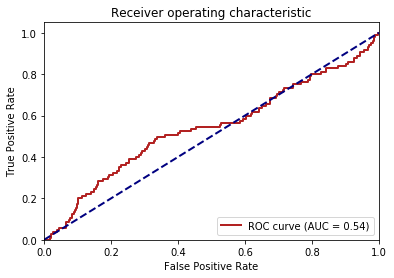

Average precision-recall score: 0.10


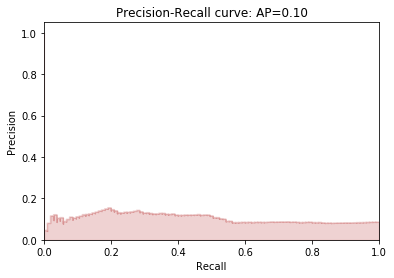

Best F1 score of  0.19367588932806323  achieved at threshold of  407714.66757453466
Corresponding vales are: Precision  0.12219451371571072  Recall:  0.4666666666666667


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 432x288 with 0 Axes>

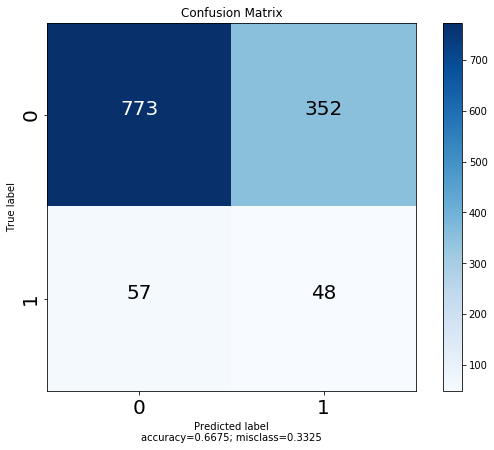

In [33]:
roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall = calc_metrics(y_gt_test, y_score_test, display_graphs=True)

np.save("Results/curves/"+grid_type+"/statistical_mean/fpr.npy", fpr)
np.save("Results/curves/"+grid_type+"/statistical_mean/tpr.npy", tpr)
np.save("Results/curves/"+grid_type+"/statistical_mean/precision.npy", precision)
np.save("Results/curves/"+grid_type+"/statistical_mean/recall.npy", recall)



In [105]:
print (mean_grid.shape)
mean_grid = np.multiply(mean_grid,255/np.max(mean_grid))
print(mean_grid.dtype)
cv2.imwrite("mean_grid.jpg", mean_grid.reshape((34,60)))




(68, 120, 2)
float16


ValueError: cannot reshape array of size 16320 into shape (34,60)

In [349]:
maxi = np.amax(mean_grid)
print (maxi)

255.0


## Modified Angle Mean for Optical Flow

In [146]:
print(flow_mag_b_train.shape)


sum_grid = np.sum(X_train, axis=0)
denom = np.where(np.sum(flow_mag_b_train, axis=0)!=0,np.sum(flow_mag_b_train, axis=0),1)
mean_grid = np.divide(sum_grid, denom)

(6559, 68, 120)


In [147]:





threshold = 100000

scores = np.zeros((X_test.shape[0]), dtype = np.float64)

dists = 0
j = 0
found_anomaly = False
interval = 2  # in seconds
interval_timer = 0
for i, (grid,frameId,second_count, flow_mag_b_)   in enumerate(zip(X_test,Id_test,sec_count_test,flow_mag_b_test)):
    dist = np.where(flow_mag_b_==1, np.power(grid-mean_grid, 2), 0)
    print(dist)
    dist = np.unwrap(dist)
    print(dist)
    #print(grid-mean_grid)
    
    var = np.amax(dist)
    
    
    scores[i] = var
    dists = dists + var
    interval_timer = interval_timer+1 
    if var > threshold and found_anomaly == False:
        j = j+1
        found_anomaly = True
        interval_timer = 0
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')
    if interval_timer*seconds == interval and found_anomaly == True:
        found_anomaly = False
    


mean = dists/frameIds.size
print(mean)



y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.14789727 0.19320438 0.13108784 ... 0.         0.         0.        ]
 [0.16429312 0.17263671 0.06304753 ... 0.         0.         0.        ]
 [0.2178838  0.003111   0.03581859 ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.14789727 0.19320

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -2.49226946 ... -6.28318531 -6.28318531
  -6.28318531]
 [ 0.          0.          2.96059807 ...  0.          0.
   0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         3.61297155 4.67682862 ... 0.         0.         0.        ]
 [0.         3.49015505 4.29329771 ... 0.         0.         0.        ]
 [0.         2.520071   3.15525205 ... 0.         0.         0.        ]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.  

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

 [0.0020828  0.17280705 0.35697803 ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.01060034 0.09096905 0.12308174 ... 0.         0.         0.        ]
 [0.00648054 0.15601546 0.29879879 ... 0.         0.         0.        ]
 [0.0020828  0.17280705 0.35697803 ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.08976807 0.14680677 0.24056917 ... 0.         0.         0.        ]
 [0.12192565 0.19459612 0.3636348  ... 0.         0.         0.        ]
 [0.17529675 0.23668367 0.42404492 ... 0.         0.         0.        ]]
[[0.         0.         0.         ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.00733561]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.00733561]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.13438239 0.14899169 0.07985773]
 [0.         0.         0.         ... 0.17634997 0.1359673  0.02163892]
 [0.         0.         0.         ... 0.09898129 0.10924567 0.0148306 ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.08419632 0.12019241 0.05954424]
 [0.         0.         0.         ... 0.14266039 0.11472321 0.013535  ]
 [0.         0.         0.         ... 0.07579355 0.08580545 0.0088264 ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.08976807 0.08136946 0.09432817 ... 0.         0.         0.        ]
 [0.05370662 0.09687513 0.16305657 ... 0.         0.         0.        ]
 [0.05665375 0.06326035 0.         ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.07006667 0.04041098 0.09507948 ... 0.         0.         0.        ]
 [0.10547196 0.08241365 0.2282711  ... 0.         0.         0.        ]
 [0.14226524 0.22681173 0.36696597 ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ... -6.28318531 -6.28318531
  -6.28318531]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.09782051 0.0833242  0.01683967]
 [0.         0.         0.         ... 0.0485112  0.05763323 0.008329  ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.     

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         4.08837342 ... 0.         0.         0.        ]
 [0.         0.         4.20472686 ... 0.         0.         0.        ]
 [0.         0.         2.91373627 ... 0.         0.         0.        ]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         5.0646975  ... 0.         0.         0.        ]
 [0.         0.         4.63155836 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.         -1.2184878  ... -6.28318531 -6.28318531
  -6.28318531]
 [ 0.          0.         -1.65162695 ... -6.28318531 -6.28318531
  -6.28318531]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+0

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.08152586 0.11467104 0.05475933]
 [0.         0.         0.         ... 0.13790561 0.11839052 0.01646164]
 [0.         0.         0.         ... 0.07660226 0.08240706 0.00564754]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [7.18175136 6.71943902 6.66940713 ... 0.         0.         0.        ]
 [7.08132211 6.59663222 6.98196035 ... 6.28318531 6.28318531 6.28318531]
 [6.63674717 5.95365959 6.13304348 ... 0.         0.         0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.000

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 6.43789564  6.9029382   6.37020135 ...  0.          0.
   0.        ]
 [ 0.          0.         -0.24735315 ... -6.28318531 -6.28318531
  -6.28318531]
 [ 0.          0.         -0.75364139 ... -6.28318531 -6.28318531
  -6.28318531]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -6.28318531 -6.28318531
  -6.28318531]
 [ 0.          0.          0.         ... -6.28318531 -6.28318531
  -6.28318531

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -6.28318531 -6.28318531
  -6.28318531]
 [ 0.          0.          0.         ... -6.28318531 -6.28318531
  -6.28318531]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.09569416 0.07942442 0.01933354]
 [0.         0.         0.         ... 0.04744171 0.05857482 0.00784603]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.11420566 0.16472

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -8.8817842e-16
  -8.8817842e-16 -8.8817842e-16]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          2.88867398  2.5198462  ...  0.          0.
   0.        ]
 [ 4.97037927  4.56570208  4.77557407 ...  0.          0.
   0.        ]
 [ 0.         -2.49296759 -2.56727328 ... -6.28318531 -6.28318531
  -6.28318531]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.11752973 0.15133119 0.24032974 ... 0.         0.         0.        ]
 [0.07333773 0.00816519 0.01523603 ... 0.         0.         0.        ]
 [0.00114706 0.00052344 0.         ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.11752973 0.15133119 0.24032974 ... 0.         0.         0.        ]
 [0.07333773 0.00816519 0.01523603 ... 0.         0.         0.        ]
 [0.00114706 0.00052344 0.         ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [4.83740537 5.00291334 3.04373002 ... 0.         0.         0.        ]
 [4.75504522 4.98384854 4.8441091  ... 0.         0.         0.        ]
 [2.62799884 4.32905121 4.47394457 ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [4.83740537 5.00291

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ... -6.28318531 -6.28318531
  -6.28318531]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.        

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  6.28318531  6.28318531
   6.28318531]
 [ 0.          0.          0.         ... -6.28318531 -6.28318531
  -6.28318531]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.13397024 0.16670906 0.27809143 ... 0.         0.         0.        ]
 [0.09526556 0.23081985 0.4038502  ... 0.         0.         0.        ]
 [0.07854388 0.16677133 0.2517764  ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.13397024 0.16670906 0.27809143 ... 0.         0.         0.        ]
 [0.09526556 0.23081985 0.4038502  ... 0.         0.         0.        ]
 [0.07854388 0.16677133 0.2517764  ... 0.         0.         0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0.

[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -8.8817842e-16
  -8.8817842e-16 -8.8817842e-16]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.     

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.07654296 0.14401388 0.2289772  ... 0.         0.         0.        ]
 [0.02677532 0.143546   0.30713017 ... 0.         0.         0.        ]
 [0.00780789 0.15637043 0.37739162 ... 0.         0.         0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 6.28318531 6.28318531 6.28318531]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.    

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.  

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -6.28318531 -6.28318531
  -6.28318531]
 [ 0.          0.          0.         ... -6.28318531 -6.28318531
  -6.28318531]
 [ 0.          0.          0.         ... -6.28318531 -6.28318531
  -6.28318531]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -6.28318531 -6.28318531
  -6.28318531]
 [ 0.          0.          0.         ...  6.28318531  6.28318531
   6.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [7.05668135 6.77016306 5.0822947  ... 0.         0.         0.        ]
 [6.54111184 6.39750255 4.30950068 ... 0.         0.         0.        ]
 [0.         4.84761923 0.         ... 0.         0.         0.        ]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 7.05668135  6.770

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.14453654 0.17929883 0.2827456  ... 0.         0.         0.        ]
 [0.14752563 0.23886476 0.39705247 ... 0.         0.         0.        ]
 [0.01454167 0.23787291 0.46405608 ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.14453654 0.17929883 0.2827456  ... 0.         0.         0.        ]
 [0.14752563 0.23886476 0.39705247 ... 0.         0.         0.        ]
 [0.01454167 0.23787291 0.4640

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.08415321 0.13328875 0.22225147 ... 0.         0.         0.        ]
 [0.08831392 0.14410153 0.33960656 ... 0.         0.         0.        ]
 [0.14097897 0.19477697 0.41016997 ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.09035421 0.10821106 0.19033962 ... 0.         0.         0.        ]
 [0.12380833 0.17365259 0.2942786  ... 0.         0.         0.        ]
 [0.18587801 0.223337   0.3825082  ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 8.8817842e-16
  8.8817842e-16 8.8817842e-16]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.06030088 0.00696405]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -6.28318531 -6.28318531
  -6.28318531]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.   

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.04941659 0.10074771 0.14974028 ... 0.         0.         0.        ]
 [0.0508631  0.05979905 0.07828307 ... 0.         0.         0.        ]
 [0.02921196 0.03270923 0.05152288 ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.04941659 0.10074771 0.14974028 ... 0.         0.         0.        ]
 [0.0508631  0.05979905 0.07828307 ... 0.         0.         0.        ]
 [0.02921196 0.03270923 0.05152288 ... 0.         0.         0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.0242021  0.04515601 0.03163292 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.  

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00089494 0.13115815 0.19852072 ... 0.         0.         0.        ]
 [0.0036581  0.09536132 0.16902529 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.09286656 0.11873503 0.18526131 ... 0.         0.         0.        ]
 [0.13721007 0.20907188 0.37790544 ... 0.         0.         0.        ]
 [0.21109985 0.26303425 0.44171317 ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [3.81926131 5.21480304 5.10874772 ... 0.         0.         0.        ]
 [0.         4.14994337 3.91358163 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 3.81926131  5.21480304  5.10874772 ...  0.          0.
   0.        ]
 [ 0.         -2.13324194 -2.36960368 ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [3.9968603  4.66796528 3.82423997 ... 0.         0.         0.        ]
 [4.56114932 5.01879166 4.37461775 ... 0.         0.         0.        ]
 [2.78869458 4.41891516 3.92974167 ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 6.28318531 6.28318531 6.28318531]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  6.28318531e+00
   6.28318531e+00  6.28318531e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.77635684e-15
  -1.77635684e-15 -1.77635684e-15]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 

 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ..

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [4.54137776 4.79541817 3.87405419 ... 0.         0.         0.        ]
 [0.         0.         3.05142248 ... 0.         0.         0.        ]
 [0.         0.         2.50261952 ... 0.         0.         0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 6.28318531 6.28318531 6.28318531]
 [0.         0.         0.    

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          3.08784721  0.         ...  0.          0.
   0.        ]
 [ 5.41535249  5.46588035  4.5478732  ... -6.28318531 -6.28318531
  -6.28318531]
 [ 5.79952235  6.04935404  4.35901888 ...  0.          0.
   0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.  

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.05336548 0.09756436 0.12086487 ... 0.         0.         0.        ]
 [0.         0.17202861 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.05336548 0.09756436 0.12086487 ... 0.         0.         0.        ]
 [0.         0.17202861 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+0

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -6.28318531 -6.28318531
  -6.28318531]
 [ 0.          0.          0.         ...  0.          0.
   0.        

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00915485 0.00335918 0.         ... 0.05545013 0.06366913 0.02167229]
 [0.         0.         0.         ... 0.12309477 0.07561809 0.00216372]
 [0.         0.         0.         ... 0.06654971 0.0630902  0.00197033]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00915485 0.00335918 0.         ... 0.05545013 0.06366913 0.02167229]
 [0.         0.         0.         ... 0.12309477 0.07561809 0.00216372]
 [0.         0.         0.         ... 0.06654971 0.0630902  0.00197033]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.25782006 0.17380153 0.11516213 ... 0.         0.         0.        ]
 [0.         0.00929414 0.19721224 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.25782006 0.17380153 0.11516213 ... 0.         0.         0.        ]
 [0.         0.00929414 0.19721224 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.14789727 0.20852013 0.24805069 ... 0.         0.         0.        ]
 [0.02374995 0.28167445 0.42204804 ... 0.         0.         0.        ]
 [0.00460423 0.32684837 0.29356059 ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.14789727 0.20852013 0.24805069 ... 0.         0.         0.        ]
 [0.02374995 0.28167445 0.42204804 ... 0.         0.         0.        ]
 [0.00460423 0.32684837 0.29356059 ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.07640793 0.11226388 0.19570255 ... 0.         0.         0.        ]
 [0.00844134 0.00533301 0.04542389 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.07640793 0.11226388 0.19570255 ... 0.         0.         0.        ]
 [0.00844134 0.00533301 0.04542389 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 8.8817842e-16
  8.8817842e-16 8.8817842e-16]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.      

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 9.97454900e-01  9.46821341e-01  7.52014160e-01 ...  1.77635684e-15
   1.77635684e-15  1.77635684e-15]
 [ 9.47848996e-01  8.48112141e-01  6.15330084e-01 ... -1.77635684e-15
  -1.77635684e-15 -1.77635684e-15]
 [ 0.00000000e+00  9.23536963e-01  5.69014141e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.11437073 0.02361187 0.         ... 0.         0.         0.        ]
 [0.0419805  0.00343668 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.11437073 0.02361

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.10200907 0.12992322 0.21449381 ... 0.         0.         0.        ]
 [0.12363659 0.18043217 0.31942797 ... 0.         0.         0.        ]
 [0.10926316 0.18921438 0.19103542 ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.10200907 0.12992322 0.21449381 ... 0.         0.         0.        ]
 [0.12363659 0.18043217 0.31942797 ... 0.         0.         0.        ]
 [0.10926316 0.18921438 0.19103542 ... 0.         0.         0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.13576341 0.17152816 0.23937321 ... 0.         0.         0.        ]
 [0.16192672 0.22337406 0.38484079 ... 0.         0.         0.        ]
 [0.23318617 0.2826703  0.43782752 ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.13576341 0.17152816 0.23937321 ... 0.         0.         0.        ]
 [0.16192672 0.22337406 0.38484079 ... 0.         0.         0.        ]
 [0.23318617 0.2826703  0.4378

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -6.28318531 -6.28318531
  -6.28318531]
 [ 0.          0.          0.         ... -6.28318531 -6.28318531
  -6.

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [1.11071031 0.99103695 0.7160399  ... 0.         0.         0.        ]
 [0.86875721 0.84721303 0.54976446 ... 0.         0.         0.        ]
 [0.72103486 0.75383179 0.49223679 ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [1.11071031 0.99103695 0.7160399  ... 0.         0.         0.        ]
 [0.86875721 0.84721303 0.54976446 ... 0.         0.         0.        ]
 [0.72103486 0.75383179 0.49223679 ... 0.         0.         0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.49296805 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.     

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

  0.0000000e+00 0.0000000e+00]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         3.45909142 ... 0.         0.         0.        ]
 [0.         0.         4.73298762 ... 0.         0.         0.        ]
 [0.         0.         4.99214443 ... 0.         0.         0.        ]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.         -2.82409388 ... -6.28318531 -6.28318531
  -6.28318531]
 [ 0.          0.         -1.55019768 ... -6.28318531 -6.28318531
  -6.28318531]
 [ 0.          0.         -1.29104087 ... -6.28318531 -6.28318531
  -6.28318531]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0

In [148]:
print(y_gt_test.shape)
print(y_score_test.shape)

(1230,)
(1230,)


ROC_AUC: 0.46


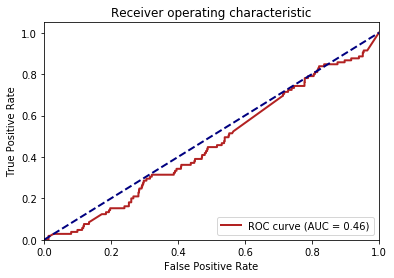

Average precision-recall score: 0.08


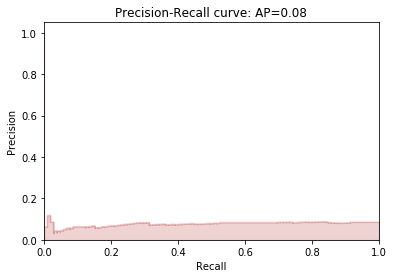

Best F1 score of  0.15756490599820946  achieved at threshold of  2.6093708114995033
Corresponding vales are: Precision  0.08695652173913043  Recall:  0.8380952380952381


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 432x288 with 0 Axes>

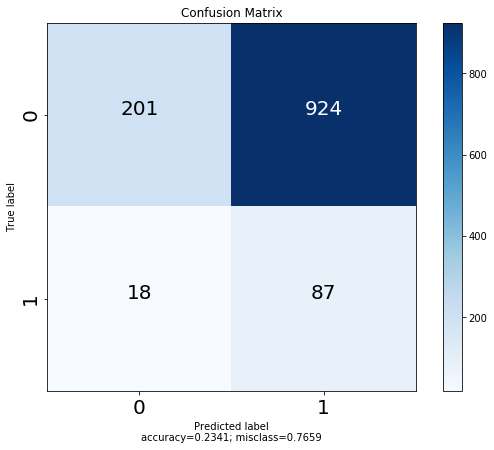

In [149]:
roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall = calc_metrics(y_gt_test, y_score_test, display_graphs=True)

np.save("Results/curves/"+grid_type+"/statistical_mean/fpr.npy", fpr)
np.save("Results/curves/"+grid_type+"/statistical_mean/tpr.npy", tpr)
np.save("Results/curves/"+grid_type+"/statistical_mean/precision.npy", precision)
np.save("Results/curves/"+grid_type+"/statistical_mean/recall.npy", recall)



## Multivariate Gaussian

In [79]:
# [7]
def covariance_matrix(X):
    m, n = X.shape 
    tmp_mat = np.zeros((n, n))
    mu = X.mean(axis=0)
    for i in range(m):
        tmp_mat += np.outer(X[i] - mu, X[i] - mu)
    return tmp_mat / m

In [80]:
# [7]
def multi_gauss_params(X):
    
    #cov_mat = covariance_matrix(X)
    cov_mat = np.cov(X, rowvar=False)
    print('Covariance matrix done')
    cov_mat_inv = np.linalg.pinv(cov_mat)
    print('Covariance matrix inverse done')
    cov_mat_det = np.linalg.det(cov_mat)
    print('Covariance matrix determinant done')
    
    return cov_mat, cov_mat_inv, cov_mat_det


In [81]:
# [7]
def multi_gauss(x, cov_mat, cov_mat_inv, cov_mat_det):
    n = len(cov_mat)
    return (np.exp(-0.5 * np.dot(x, np.dot(cov_mat_inv, x.T))) )
            #/ (2. * np.pi)**(n/2.) 
            #/ np.sqrt(cov_mat_det))

In [109]:


X_train_flat, X_test_flat = X_train.reshape((len(X_train), np.prod(X_train.shape[1:]))), X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

X_train_flat = np.array(X_train_flat, dtype=np.float64)
X_test_flat = np.array(X_test_flat, dtype=np.float64)

#X_train_flat = np.multiply(X_train_flat, 2)
#X_test_flat = np.multiply(X_test_flat, 2)

print(X_train_flat)


[[ 1.89876556e-03  5.08785248e-04  3.35311890e-03 ... -7.08007812e-02
   1.98730469e-01 -3.72009277e-02]
 [ 7.11441040e-04 -6.99162483e-05  1.10244751e-03 ...  4.41406250e-01
  -3.35693359e-01  3.46191406e-01]
 [ 6.50024414e-03 -5.17368317e-04  1.47552490e-02 ... -3.61328125e-01
  -9.15527344e-02 -3.06640625e-01]
 ...
 [-3.75488281e-01  8.30688477e-02 -7.21679688e-01 ...  1.04064941e-01
   2.77343750e-01  1.34521484e-01]
 [-2.99804688e-01  9.17968750e-02 -3.91601562e-01 ...  4.91943359e-02
   6.51245117e-02  4.28466797e-02]
 [-6.84814453e-02 -1.98554993e-03 -1.23962402e-01 ...  1.77612305e-02
   3.75976562e-01  3.79333496e-02]]


In [ ]:
cov_mat, cov_mat_inv, cov_mat_det = multi_gauss_params(X_train_flat)



Covariance matrix done


In [1]:
print(cov_mat_inv)
print(cov_mat_det)

NameError: name 'cov_mat_inv' is not defined

In [356]:

threshold = 900

scores = np.zeros((X_test.shape[0]), dtype = np.float64)

dists = 0
j = 0
found_anomaly = False
interval = 2  # in seconds
interval_timer = 0
for i, (grid,frameId,second_count)   in enumerate(zip(X_test_flat,Id_test,sec_count_test)):
    grid_numeric = np.array(grid, dtype = np.float64)
    one_minus_prob = 1-multi_gauss(grid, cov_mat, cov_mat_inv, cov_mat_det)
    print(one_minus_prob)
    scores[i] = one_minus_prob
    dists = dists + one_minus_prob
    interval_timer = interval_timer+1 
    if one_minus_prob > threshold and found_anomaly == False:
        j = j+1
        found_anomaly = True
        interval_timer = 0
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')
    if interval_timer*seconds == interval and found_anomaly == True:
        found_anomaly = False
    


mean = dists/frameIds.size
print(mean)



y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])



1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


ROC_AUC: 0.50


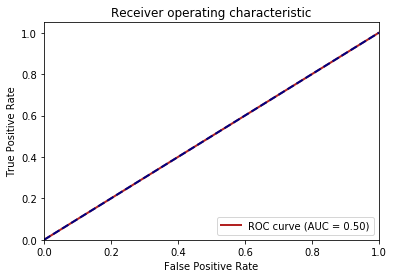

Average precision-recall score: 0.09


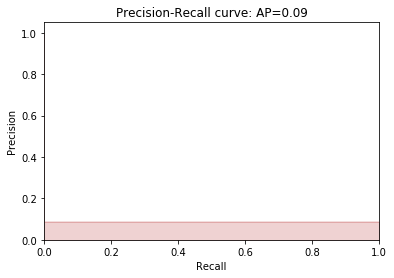

Best F1 score of  0.15730337078651685  achieved at threshold of  1.0
Corresponding vales are: Precision  0.08536585365853659  Recall:  1.0


<Figure size 432x288 with 0 Axes>

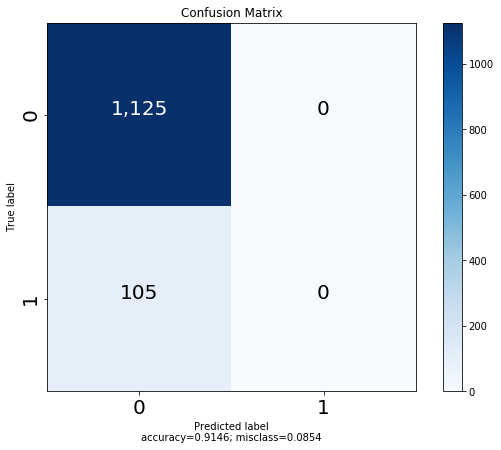

In [357]:
roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall = calc_metrics(y_gt_test, y_score_test, display_graphs=True)

np.save("Results/curves/"+grid_type+"/mult_gauss/fpr.npy", fpr)
np.save("Results/curves/"+grid_type+"/mult_gauss/tpr.npy", tpr)
np.save("Results/curves/"+grid_type+"/mult_gauss/precision.npy", precision)
np.save("Results/curves/"+grid_type+"/mult_gauss/recall.npy", recall)



### Modified Multivariate Gaussian

In [358]:
coordinates_train = []


for index, loc in np.ndenumerate(X_train):
    if loc == 1:
        if X_train.shape[1] == 2:
            coordinates_train.append([index[1],index[2],index[3]])
        else:
            coordinates_train.append([index[2],index[3]])


        
coordinates_train = np.array(coordinates_train, dtype=np.int8)


In [359]:
print(coordinates_train.shape)
print(coordinates_train.dtype)
print(coordinates_train)

(2151487, 3)
int8
[[ 0  4 37]
 [ 0  4 38]
 [ 0  4 39]
 ...
 [ 1 33 57]
 [ 1 33 58]
 [ 1 33 59]]


In [360]:
cov_mat, cov_mat_inv, cov_mat_det = multi_gauss_params(coordinates_train)




Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done


In [361]:
print(cov_mat_inv)
print(cov_mat_det)

[[ 4.38391775e+00  2.26027227e-03 -3.45664458e-02]
 [ 2.26027227e-03  1.42690883e-02  1.55254499e-03]
 [-3.45664458e-02  1.55254499e-03  4.50741366e-03]]
3935.8119444027093


In [362]:

threshold = 900

scores = np.zeros((X_test.shape[0]), dtype = np.float64)

dists = 0
j = 0
found_anomaly = False
interval = 2  # in seconds
interval_timer = 0
for i, (grid,frameId,second_count)   in enumerate(zip(X_test,Id_test,sec_count_test)):
    probabilities = []
    
    for index, loc in np.ndenumerate(grid):
        if loc == 1:
            
            if X_train.shape[1] == 2:
                one_minus_prob = 1-multi_gauss(np.array([index[0],index[1],index[2]]), cov_mat, cov_mat_inv, cov_mat_det)
            else:
                one_minus_prob = 1-multi_gauss(np.array([index[1],index[2]]), cov_mat, cov_mat_inv, cov_mat_det)

            probabilities.append(one_minus_prob)
    
    if len(probabilities) > 0:
        score = max(probabilities)
    else:
        score = 0
    #print(score)
    scores[i] = score
    dists = dists + score
    interval_timer = interval_timer+1 
    if score > threshold and found_anomaly == False:
        j = j+1
        found_anomaly = True
        interval_timer = 0
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')
    if interval_timer*seconds == interval and found_anomaly == True:
        found_anomaly = False
    


mean = dists/frameIds.size
print(mean)



y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])




0.599976629503949


ROC_AUC: 0.53


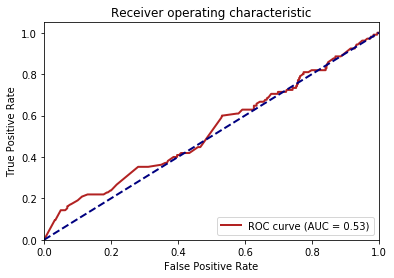

Average precision-recall score: 0.11


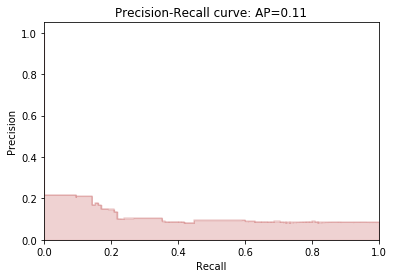

Best F1 score of  0.17254901960784316  achieved at threshold of  0.9999999750881601
Corresponding vales are: Precision  0.14666666666666667  Recall:  0.20952380952380953


<Figure size 432x288 with 0 Axes>

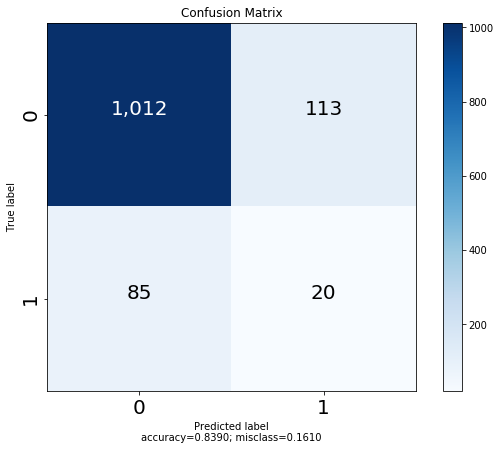

In [363]:
roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall = calc_metrics(y_gt_test, y_score_test, display_graphs=True)



np.save("Results/curves/"+grid_type+"/mult_gauss_modified/fpr.npy", fpr)
np.save("Results/curves/"+grid_type+"/mult_gauss_modified/tpr.npy", tpr)
np.save("Results/curves/"+grid_type+"/mult_gauss_modified/precision.npy", precision)
np.save("Results/curves/"+grid_type+"/mult_gauss_modified/recall.npy", recall)




## Autoencoder

### 1D Autoencoder

In [34]:


X_train_flat, X_test_flat = X_train.reshape((len(X_train), np.prod(X_train.shape[1:]))), X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))


In [35]:
input_dim = np.prod(grids.shape[1:])
encoding_dim = 42

print(input_dim)

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

16320


In [36]:
nb_epoch = 50
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="models/model.h5",
                               verbose=0,
                               save_best_only=True)


history = autoencoder.fit(X_train_flat, X_train_flat,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test_flat, X_test_flat),
                    verbose=1,
                    callbacks=[checkpointer]).history

Train on 6559 samples, validate on 9838 samples
Epoch 1/50
6559/6559 [==============================] - 15s 2ms/step - loss: 10.2772 - acc: 6.0985e-04 - val_loss: 9.6252 - val_acc: 7.1153e-04
Epoch 2/50
6559/6559 [==============================] - 13s 2ms/step - loss: 9.2263 - acc: 9.1477e-04 - val_loss: 8.9965 - val_acc: 9.1482e-04
Epoch 3/50
6559/6559 [==============================] - 13s 2ms/step - loss: 8.7201 - acc: 0.0017 - val_loss: 8.6741 - val_acc: 7.1153e-04
Epoch 4/50
6559/6559 [==============================] - 13s 2ms/step - loss: 8.4196 - acc: 0.0020 - val_loss: 8.4595 - val_acc: 9.1482e-04
Epoch 5/50
6559/6559 [==============================] - 13s 2ms/step - loss: 8.1794 - acc: 9.1477e-04 - val_loss: 8.2585 - val_acc: 0.0012
Epoch 6/50
6559/6559 [==============================] - 13s 2ms/step - loss: 7.9636 - acc: 0.0017 - val_loss: 8.0438 - val_acc: 0.0013
Epoch 7/50
6559/6559 [==============================] - 13s 2ms/step - loss: 7.7091 - acc: 0.0015 - val_loss: 7.7

In [37]:
autoencoder = load_model('models/model.h5')

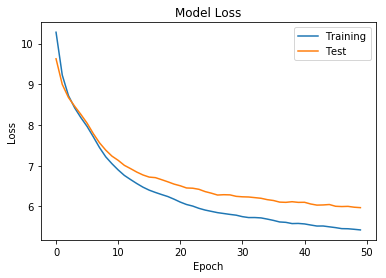

In [38]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'], loc='upper right');

In [39]:
predictions = autoencoder.predict(X_test_flat)

In [40]:
mse = np.mean(np.power(X_test_flat - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'frameId': Id_test,
                        'second_count': sec_count_test})


In [33]:
threshold = 0.08
interval = 2  # in seconds

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
pred_frameIds = []
pred_second_counts = []
for y,frameId,sec_count in zip(y_pred, Id_test, sec_count_test):
    if y==1:
        pred_frameIds.append(frameId)
        pred_second_counts.append(sec_count)
pred_frameIds.sort()
pred_second_counts.sort()


for i, second_count in enumerate(pred_second_counts):
    if second_count-pred_second_counts[max(i-1,0)] > interval:
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')
    


Anomaly detected at :  36  mins  49  seconds
Anomaly detected at :  55  mins  51  seconds
Anomaly detected at :  57  mins  51  seconds
Anomaly detected at :  58  mins  52  seconds
Anomaly detected at :  63  mins  34  seconds
Anomaly detected at :  65  mins  20  seconds


In [34]:


y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(error_df.reconstruction_error.values[clip_size*i:clip_size*(i+1)])
    

ROC_AUC: 0.52


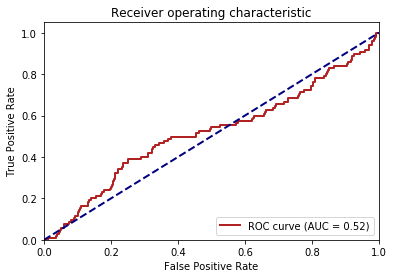

Average precision-recall score: 0.10


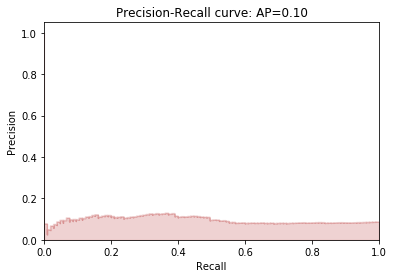

Best F1 score of  0.1911421911421911  achieved at threshold of  15.093393325805664
Corresponding vales are: Precision  0.12654320987654322  Recall:  0.3904761904761905


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 432x288 with 0 Axes>

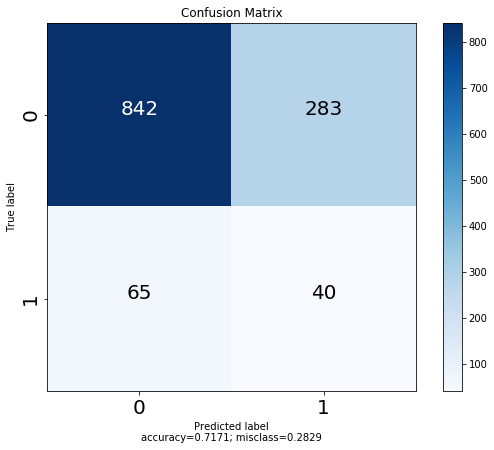

In [35]:
roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall = calc_metrics(y_gt_test, y_score_test, display_graphs=True)



np.save("Results/curves/"+grid_type+"/1D_autoencoder/fpr.npy", fpr)
np.save("Results/curves/"+grid_type+"/1D_autoencoder/tpr.npy", tpr)
np.save("Results/curves/"+grid_type+"/1D_autoencoder/precision.npy", precision)
np.save("Results/curves/"+grid_type+"/1D_autoencoder/recall.npy", recall)




### 2D Convolutional Autoencoder

In [57]:
input_dim = (grids.shape[1], grids.shape[2], grids.shape[3])

print(input_dim)


input_img = Input(shape=input_dim)  # adapt this if using `channels_first` image data format

x = Conv2D(8, (3, 3), activation='relu', padding='same', data_format="channels_first")(input_img)
x = MaxPooling2D((2, 2), padding='same', data_format="channels_first")(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same', data_format="channels_first")(x)
x = MaxPooling2D((2, 2), padding='same', data_format="channels_first")(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same', data_format="channels_first")(x)
encoded = MaxPooling2D((2, 2), padding='same', data_format="channels_first")(x)


x = Conv2D(4, (3, 3), activation='relu', padding='same', data_format="channels_first")(encoded)
x = UpSampling2D((2, 2), data_format="channels_first")(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same', data_format="channels_first")(x)
x = UpSampling2D((2, 2), data_format="channels_first")(x)
x = Conv2D(8, (1, 4), activation='relu', data_format="channels_first")(x)
x = UpSampling2D((2, 2), data_format="channels_first")(x)
decoded = Conv2D(grids.shape[1], (3, 3), activation='sigmoid', padding='same', data_format="channels_first")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

(68, 120, 2)


In [58]:
checkpointer = ModelCheckpoint(filepath="models/model_2D_conv.h5",
                               verbose=0,
                               save_best_only=True)


history = autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[checkpointer]).history

Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 85s 13ms/step - loss: -2.0085 - val_loss: -6.1626
Epoch 2/10
6559/6559 [==============================] - 86s 13ms/step - loss: -6.4953 - val_loss: -6.6941
Epoch 3/10
6559/6559 [==============================] - 86s 13ms/step - loss: -6.7912 - val_loss: -6.8636
Epoch 4/10
6559/6559 [==============================] - 82s 13ms/step - loss: -6.9225 - val_loss: -6.9811
Epoch 5/10
6559/6559 [==============================] - 81s 12ms/step - loss: -7.0097 - val_loss: -7.0377
Epoch 6/10
6559/6559 [==============================] - 85s 13ms/step - loss: -7.0724 - val_loss: -7.1389
Epoch 7/10
6559/6559 [==============================] - 83s 13ms/step - loss: -7.1964 - val_loss: -7.3192
Epoch 8/10
6559/6559 [==============================] - 83s 13ms/step - loss: -7.3158 - val_loss: -7.4305
Epoch 9/10
6559/6559 [==============================] - 86s 13ms/step - loss: -7.3967 - val_loss: -7.460

In [59]:
autoencoder = load_model('models/model_2D_conv.h5')

In [60]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 68, 120, 2)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 8, 120, 2)         4904      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 60, 1)          0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 4, 60, 1)          292       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 4, 30, 1)          0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 4, 30, 1)          148       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 4, 15, 1)          0         
__________

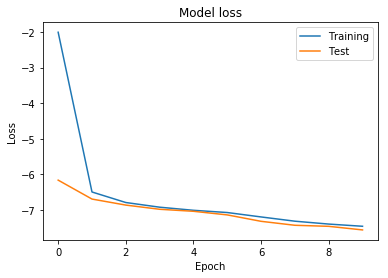

In [61]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'], loc='upper right');

In [62]:
predictions = autoencoder.predict(X_test)

In [63]:
mse = np.mean(np.power(X_test - predictions, 2), axis=(1,2,3))
print(mse.shape)
error_df = pd.DataFrame({'reconstruction_error': mse.reshape((len(mse),)),
                        'frameId': Id_test,
                        'second_count': sec_count_test})




(9838,)


In [64]:
threshold = 0.015
interval = 1

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
pred_frameIds = []
pred_second_counts = []
for y,frameId,sec_count in zip(y_pred, Id_test, sec_count_test):
    if y==1:
        pred_frameIds.append(frameId)
        pred_second_counts.append(sec_count)
pred_frameIds.sort()
pred_second_counts.sort()


for i, second_count in enumerate(pred_second_counts):
    if second_count-pred_second_counts[max(i-1,0)] > interval:
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')
    


    



In [65]:


y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(error_df.reconstruction_error.values[clip_size*i:clip_size*(i+1)])
    

ROC_AUC: 0.54


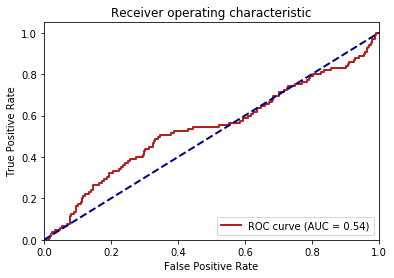

Average precision-recall score: 0.10


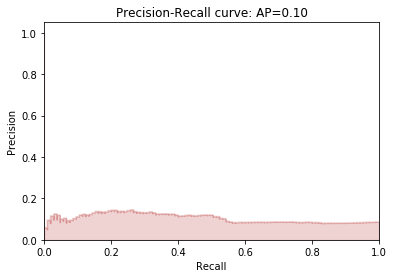

Best F1 score of  0.19378427787934185  achieved at threshold of  23.27730369567871
Corresponding vales are: Precision  0.11990950226244344  Recall:  0.5047619047619047


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 432x288 with 0 Axes>

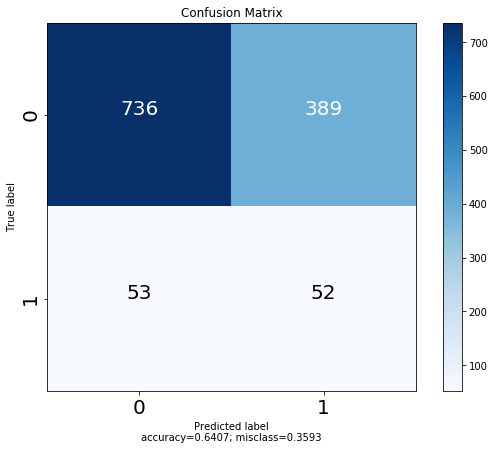

In [66]:
roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall = calc_metrics(y_gt_test, y_score_test, display_graphs=True)



np.save("Results/curves/"+grid_type+"/2D_autoencoder/fpr.npy", fpr)
np.save("Results/curves/"+grid_type+"/2D_autoencoder/tpr.npy", tpr)
np.save("Results/curves/"+grid_type+"/2D_autoencoder/precision.npy", precision)
np.save("Results/curves/"+grid_type+"/2D_autoencoder/recall.npy", recall)






## Region Based Approach

### Variance

In [67]:
vertical_divisions = 10  # Actual number of divisions will vary after precision loss from rounding
horizontal_divisions = 10

#region_w = int(round(X_train.shape[3]/horizontal_divisions))
#region_h = int(round(X_train.shape[2]/vertical_divisions))

region_w = 3
region_h = 3



In [68]:
print(X_test.shape)

print(X_test.dtype)



(9838, 68, 120, 2)
float16


In [69]:

if (grid_type == 'flow_avg') or (grid_type == 'flow_max'):
    region_scores = np.zeros((X_test.shape[0],int(ceil(X_train.shape[1]/region_h)),int(ceil(X_train.shape[2]/region_w))), dtype = np.float64)
    
else:
    region_scores = np.zeros((X_test.shape[0],int(ceil(X_train.shape[2]/region_h)),int(ceil(X_train.shape[3]/region_w))), dtype = np.float64)
    

num_r_x = region_scores.shape[2]
num_r_y = region_scores.shape[1]
region_scores.shape


(9838, 23, 40)

In [70]:
mean_grid = np.mean(X_train, axis=0)
print(mean_grid.shape)


for i in range(num_r_x): # horizontal index
    for j in range(num_r_y): # vertical index
        
        
        if (grid_type == 'flow_avg') or (grid_type == 'flow_max'):
            X_train_r = X_train[:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
            X_test_r = X_test[:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
            # print('(',region_h*j,'-',region_h*(j+1),')   (',region_w*i,'-',region_w*(i+1),')')

            mean_grid_r = mean_grid[region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]

        else:
            X_train_r = X_train[:,:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
            X_test_r = X_test[:,:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
            # print('(',region_h*j,'-',region_h*(j+1),')   (',region_w*i,'-',region_w*(i+1),')')

            mean_grid_r = mean_grid[:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
        
        
        ######################################################################
        
        
        print(X_test_r.shape)
        
        if (grid_type == 'flow_avg') or (grid_type == 'flow_max'):
            var = np.mean(np.amax(X_test_r - mean_grid_r, axis=1), axis=(1,2))

        else:
            var = np.amax(np.amax(np.power(X_test_r - mean_grid_r, 2), axis=3), axis=(1,2))
        
        print(var)
        
        error_df = pd.DataFrame({'variance': var})
        
        region_scores[:,j,i] = error_df.variance.values




        

(68, 120, 2)
(9838, 3, 3, 2)
[0.03668 0.1156  0.05032 ... 0.1577  0.18    0.156  ]
(9838, 3, 3, 2)
[ 0.02803  0.1853   0.05093 ... -0.01354  0.07635  0.1209 ]
(9838, 3, 3, 2)
[-0.01915  0.11554  0.0347  ...  0.06934  0.10803  0.155  ]
(9838, 3, 3, 2)
[-0.0836   0.01357  0.02435 ...  0.09454  0.04208  0.0518 ]
(9838, 3, 3, 2)
[-0.10815   0.03038  -0.00889  ...  0.0907    0.005817  0.0727  ]
(9838, 3, 3, 2)
[-0.1005    0.02493  -0.01604  ...  0.09595   0.008385  0.06165 ]
(9838, 3, 3, 2)
[-0.1046   0.02124 -0.01257 ...  0.075   -0.05295  0.07184]
(9838, 3, 3, 2)
[-0.2603  -0.1346  -0.1577  ... -0.04187 -0.2118  -0.05847]
(9838, 3, 3, 2)
[-0.395  -0.337   2.738  ... -0.2427 -0.3293 -0.2399]
(9838, 3, 3, 2)
[-0.438  -0.462   5.137  ... -0.3315 -0.4922 -0.2686]
(9838, 3, 3, 2)
[-0.443  -0.3623  3.945  ... -0.388  -0.4907 -0.2072]
(9838, 3, 3, 2)
[-0.321  -0.314   3.562  ...  2.04    2.34    0.1255]
(9838, 3, 3, 2)
[-0.3518 -0.3625  6.59   ...  1.742   2.191   0.583 ]
(9838, 3, 3, 2)
[-0.404

[-0.3606 -0.3337 -0.302  ... -0.2078 -0.2496 -0.2441]
(9838, 3, 3, 2)
[-0.4426 -0.2888 -0.433  ... -0.3582 -0.525  -0.2124]
(9838, 3, 3, 2)
[-0.4895  -0.285   -0.3733  ... -0.08167 -0.4312  -0.11145]
(9838, 3, 3, 2)
[-0.418   -0.3008  -0.3035  ... -0.09576 -0.249    0.04868]
(9838, 3, 3, 2)
[-0.3865 -0.3162 -0.3235 ... -0.3098 -0.3281 -0.214 ]
(9838, 3, 3, 2)
[-0.426  -0.333  -0.406  ... -0.413  -0.41   -0.2421]
(9838, 3, 3, 2)
[-0.4648 -0.4285 -0.4907 ... -0.463  -0.529  -0.2308]
(9838, 3, 3, 2)
[-0.4854 -0.4407 -0.4653 ... -0.4407 -0.4407 -0.3188]
(9838, 3, 3, 2)
[-0.5327 -0.509  -0.495  ... -0.4788 -0.5254 -0.3997]
(9838, 3, 3, 2)
[-0.6484 -0.663  -0.779  ... -0.785  -0.8774 -0.687 ]
(9838, 3, 3, 2)
[-0.8555 -0.7627 -0.793  ... -0.8735 -0.9165 -0.7515]
(9838, 3, 3, 2)
[-0.7207 -0.772  -0.717  ... -0.796  -0.8384 -0.682 ]
(9838, 3, 3, 2)
[-0.764  -0.721  -0.741  ... -0.757  -0.793  -0.6914]
(9838, 3, 3, 2)
[-0.8755 -0.8784  8.516  ... -0.9004 -0.9575 -0.805 ]
(9838, 3, 3, 2)
[-0.8716

[-0.923  -0.8936 -0.976  ... -0.9053 -0.9795 -0.8584]
(9838, 3, 3, 2)
[-0.8423 -0.788  -0.917  ... -0.9    -0.9683 -0.7695]
(9838, 3, 3, 2)
[-0.4766 -0.4692 -0.4893 ... -0.4775 -0.4917 -0.5186]
(9838, 3, 3, 2)
[-0.1808 -0.2142 -0.202  ... -0.2566 -0.3037 -0.1473]
(9838, 3, 3, 2)
[-0.1242  -0.03745 -0.093   ... -0.1214  -0.0959  -0.0923 ]
(9838, 3, 3, 2)
[-0.03458 -0.0166  -0.05405 ... -0.0419  -0.04086 -0.0477 ]
(9838, 2, 3, 2)
[-0.04117 -0.01904 -0.01897 ... -0.02693 -0.0701  -0.00358]
(9838, 3, 3, 2)
[-0.04083  0.03123  0.0628  ...  0.05597  0.0888   0.0697 ]
(9838, 3, 3, 2)
[-0.06024  0.0327   0.0703  ...  0.04175  0.0742   0.03497]
(9838, 3, 3, 2)
[-0.0736   0.01884  0.06177 ...  0.05856  0.0589   0.02267]
(9838, 3, 3, 2)
[-0.09735  -0.003351 -0.01058  ...  0.04703   0.05853   0.004154]
(9838, 3, 3, 2)
[-0.1935  -0.07007 -0.061   ... -0.01544 -0.01813 -0.07404]
(9838, 3, 3, 2)
[-0.2737  -0.1152  -0.1465  ... -0.0728  -0.12164 -0.09515]
(9838, 3, 3, 2)
[-0.2034  -0.1155  -0.117   ..

[-0.2737 -0.2142 -0.1871 ...  0.9355  3.371   2.352 ]
(9838, 3, 3, 2)
[-0.2118  -0.05728 -0.07294 ...  0.4045  -0.9663  -1.493  ]
(9838, 3, 3, 2)
[ 4.863   3.28   -0.2465 ...  0.278  -0.5195  3.115 ]
(9838, 3, 3, 2)
[ 5.098  8.33  -0.605 ... -0.608  4.266 -0.9  ]
(9838, 3, 3, 2)
[11.     11.43   -0.9795 ... -0.988  -0.5635  2.861 ]
(9838, 3, 3, 2)
[10.67  10.91  -1.024 ... -1.039 -1.038  2.129]
(9838, 3, 3, 2)
[13.43   10.88   -0.7153 ... -0.713  -0.735  -0.65  ]
(9838, 3, 3, 2)
[13.04   12.945  -0.2527 ... -0.2605 -0.3179 -0.2605]
(9838, 3, 3, 2)
[ 7.145e+00  6.941e+00 -7.587e-02 ... -4.559e-02 -9.198e-02  6.470e-03]
(9838, 3, 3, 2)
[-0.00941  0.03186 -0.01958 ...  0.01315 -0.0293   0.05603]
(9838, 3, 3, 2)
[ 0.008316  0.03073  -0.02217  ...  0.00578  -0.0962    0.02979 ]
(9838, 3, 3, 2)
[ 0.004223  0.0128    0.05057  ...  0.02126  -0.0635    0.04327 ]
(9838, 2, 3, 2)
[-5.634e-02  2.798e-02  7.629e-05 ...  1.319e-02 -3.683e-02  3.531e-02]
(9838, 3, 3, 2)
[-0.0834    0.003658  0.0832  

(9838, 3, 3, 2)
[-0.2666  -0.1526  -0.05615 ... -0.1326  -0.04346 -0.1249 ]
(9838, 3, 3, 2)
[-0.253   -0.1389  -0.05194 ... -0.09186 -0.04068 -0.143  ]
(9838, 3, 3, 2)
[-0.3599 -0.2012 -0.2084 ... -0.1481 -0.1466 -0.1655]
(9838, 3, 3, 2)
[-0.1471   0.01117  0.01616 ...  0.1613   1.149    0.2595 ]
(9838, 3, 3, 2)
[-0.1594 -0.0513 -0.0242 ...  0.7095  0.4536  2.018 ]
(9838, 3, 3, 2)
[-0.147   -0.04736  0.01624 ...  0.6567   1.253   -0.0781 ]
(9838, 3, 3, 2)
[-0.1548  -0.0986  -0.07007 ...  2.271    0.9814  -0.3027 ]
(9838, 3, 3, 2)
[-0.1613 -0.1886 -0.1488 ...  1.519   1.21    1.6045]
(9838, 3, 3, 2)
[-0.1421   -0.11865  -0.092    ...  1.066     0.005493  1.377   ]
(9838, 3, 3, 2)
[-0.2269 -0.1925 -0.1826 ...  1.8    -0.2225 -0.1039]
(9838, 3, 3, 2)
[-0.3818  10.3     -0.269   ... -0.2192  -0.2761  -0.10535]
(9838, 3, 3, 2)
[ 3.139  12.805   1.807  ... -0.6094 -0.7007 -0.7075]
(9838, 3, 3, 2)
[11.23  12.06  12.5   ... -1.246 -1.222 -1.17 ]
(9838, 3, 3, 2)
[ 7.824 11.8   12.5   ... -1.423

[-0.01764  0.03564 -0.01776 ...  0.03854 -0.02794 -0.0473 ]
(9838, 3, 3, 2)
[-0.01075  0.03812 -0.02019 ...  0.0337  -0.03275 -0.05115]
(9838, 2, 3, 2)
[-0.00706   0.05588   0.005074 ...  0.02686  -0.03787  -0.04288 ]
(9838, 3, 3, 2)
[0.1897 0.4143 0.4434 ... 0.899  0.9    0.9893]
(9838, 3, 3, 2)
[0.3218  0.04333 0.1509  ... 0.3223  0.3477  0.1515 ]
(9838, 3, 3, 2)
[-0.1765  0.0349  0.1523 ...  0.3909  0.6924  0.6865]
(9838, 3, 3, 2)
[ 0.8364    1.131     0.95     ...  0.0397    0.1669   -0.001737]
(9838, 3, 3, 2)
[ 0.7144   0.9087   0.6123  ...  0.00882  0.04614 -0.03336]
(9838, 3, 3, 2)
[-0.1747    0.02834   0.013824 ...  0.0423   -0.0497   -0.0953  ]
(9838, 3, 3, 2)
[-0.1427  -0.07874 -0.05783 ... -0.03873 -0.04645 -0.09814]
(9838, 3, 3, 2)
[-0.1755   -0.0845   -0.05377  ...  0.014656 -0.05405  -0.0704  ]
(9838, 3, 3, 2)
[-0.0752    -0.0534    -0.09595   ...  0.0001627 -0.04706   -0.005188 ]
(9838, 3, 3, 2)
[-0.0983  -0.06604 -0.082   ... -0.03738 -0.0275  -0.02763]
(9838, 3, 3, 2)


[-0.3955 -0.2482 -0.268  ... -0.2343 -0.3052 -0.2542]
(9838, 3, 3, 2)
[-0.6807 -0.618  -0.664  ... -0.3843 -0.7    -0.5693]
(9838, 3, 3, 2)
[ 2.037  -1.087  -1.099  ... -0.96   -1.01   -0.9546]
(9838, 3, 3, 2)
[ 3.877 -1.266 -1.292 ... -1.219 -1.269 -1.328]
(9838, 3, 3, 2)
[ 1.3125 -1.169  -1.133  ... -1.19   -1.132  -1.268 ]
(9838, 3, 3, 2)
[-0.842  -0.746  -0.854  ... -0.8335 -0.8735 -0.825 ]
(9838, 3, 3, 2)
[-0.1724 -0.3105 -0.4272 ... -0.4492 -0.3828 -0.4875]
(9838, 3, 3, 2)
[-0.09985 -0.0686  -0.04468 ... -0.05698 -0.05066 -0.1249 ]
(9838, 3, 3, 2)
[-0.08386    0.0004094 -0.01317   ... -0.003366  -0.01425   -0.05872  ]
(9838, 3, 3, 2)
[-0.1644  -0.05707  0.1577  ... -0.05444 -0.115   -0.02904]
(9838, 2, 3, 2)
[-0.07654   0.0696    0.4512   ...  0.005756  0.02267  -0.02663 ]
(9838, 3, 3, 2)
[-0.09393  0.06555  0.2007  ...  0.06012  0.1135   0.03363]
(9838, 3, 3, 2)
[-0.1129   0.08075  0.11523 ...  0.2388   0.12366  0.1236 ]
(9838, 3, 3, 2)
[0.1039 0.113  0.2405 ... 0.31   0.1881 0.

(9838, 3, 3, 2)
[-0.223   -0.04453 -0.1406  ... -0.1812  -0.252   -0.1698 ]
(9838, 3, 3, 2)
[-0.3643 -0.2727 -0.234  ... -0.2346 -0.354  -0.316 ]
(9838, 3, 3, 2)
[-0.316  -0.2988 -0.2742 ... -0.2754 -0.2964 -0.2788]
(9838, 3, 3, 2)
[ 0.1175 -0.1888 -0.2866 ... -0.2808 -0.3008 -0.2615]
(9838, 3, 3, 2)
[20.61   -0.2888 -0.4673 ... -0.4277 -0.3826 -0.4768]
(9838, 3, 3, 2)
[21.42   -1.016  -0.94   ... -0.8843 -0.996  -1.064 ]
(9838, 3, 3, 2)
[22.64   -1.0205 -0.99   ... -0.7847 -0.9136 -0.691 ]
(9838, 3, 3, 2)
[17.81  15.84  -1.133 ... -1.053 -1.161 -1.063]
(9838, 3, 3, 2)
[22.16  20.12  -1.274 ... -1.308 -1.349 -1.326]
(9838, 3, 3, 2)
[22.08  20.23  -1.154 ... -1.262 -1.265 -1.28 ]
(9838, 3, 3, 2)
[21.27   9.93  -0.91  ... -0.963 -1.08  -1.095]
(9838, 3, 3, 2)
[31.28    4.105  -0.5015 ... -0.474  -0.5693 -0.5776]
(9838, 3, 3, 2)
[ 2.417e+01  2.699e-02 -1.139e-01 ...  1.171e-02 -1.252e-02 -1.559e-02]
(9838, 3, 3, 2)
[-0.07416  0.08386 -0.04858 ...  0.0401   0.03406 -0.0857 ]
(9838, 2, 3, 2

In [71]:
scores = np.amax(region_scores, axis=(1,2))

y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])
    

ROC_AUC: 0.46


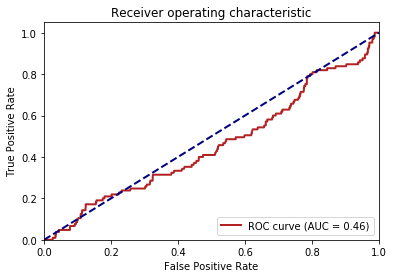

Average precision-recall score: 0.08


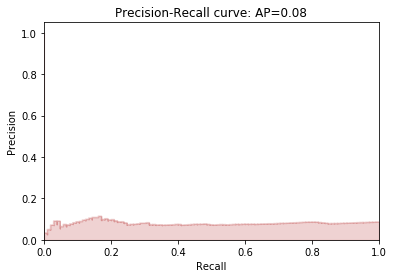

Best F1 score of  0.15897047691143074  achieved at threshold of  2.66796875
Corresponding vales are: Precision  0.08634868421052631  Recall:  1.0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 432x288 with 0 Axes>

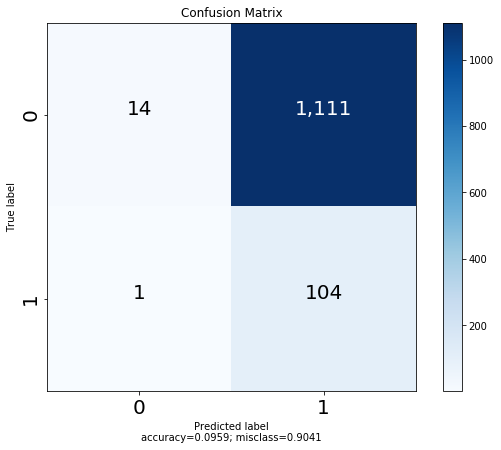

In [72]:
roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall = calc_metrics(y_gt_test, y_score_test, display_graphs=True)


np.save("Results/curves/"+grid_type+"/region_based_var_from_mean/fpr.npy", fpr)
np.save("Results/curves/"+grid_type+"/region_based_var_from_mean/tpr.npy", tpr)
np.save("Results/curves/"+grid_type+"/region_based_var_from_mean/precision.npy", precision)
np.save("Results/curves/"+grid_type+"/region_based_var_from_mean/recall.npy", recall)





In [73]:
threshold = 0.4
interval = 1

y_pred = [1 if e > threshold else 0 for e in scores]
pred_frameIds = []
pred_second_counts = []
for y,frameId,sec_count in zip(y_pred, Id_test, sec_count_test):
    if y==1:
        pred_frameIds.append(frameId)
        pred_second_counts.append(sec_count)
pred_frameIds.sort()
pred_second_counts.sort()


for i, second_count in enumerate(pred_second_counts):
    if second_count-pred_second_counts[max(i-1,0)] > interval:
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')

### Multivariate Gaussian

In [82]:
def multi_gauss(x, cov_mat, cov_mat_inv, cov_mat_det):
    n = len(cov_mat)
    return (np.exp(-0.5 * np.dot(x, np.dot(cov_mat_inv, x.T))) )
            #/ (2. * np.pi)**(n/2.) 
            #/ np.sqrt(cov_mat_det))

In [83]:
vertical_divisions = 10  # Actual number of divisions will vary after precision loss from rounding
horizontal_divisions = 10

#region_w = int(round(X_train.shape[3]/horizontal_divisions))
#region_h = int(round(X_train.shape[2]/vertical_divisions))

region_w = 3
region_h = 3



In [84]:
print(X_test.shape)

(9838, 68, 120, 2)


In [85]:

if (grid_type == 'flow_avg') or (grid_type == 'flow_max'):
    region_scores = np.zeros((X_test.shape[0],int(ceil(X_train.shape[1]/region_h)),int(ceil(X_train.shape[2]/region_w))), dtype = np.float64)
    
else:
    region_scores = np.zeros((X_test.shape[0],int(ceil(X_train.shape[2]/region_h)),int(ceil(X_train.shape[3]/region_w))), dtype = np.float64)
    

num_r_x = region_scores.shape[2]
num_r_y = region_scores.shape[1]
region_scores.shape


(9838, 23, 40)

In [86]:
mean_grid = np.mean(X_train, axis=0)
print(mean_grid.shape)


for i in range(num_r_x): # horizontal index
    for j in range(num_r_y): # vertical index
        
        
        if (grid_type == 'flow_avg') or (grid_type == 'flow_max'):
            X_train_r = X_train[:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
            X_test_r = X_test[:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
            # print('(',region_h*j,'-',region_h*(j+1),')   (',region_w*i,'-',region_w*(i+1),')')

            mean_grid_r = mean_grid[region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]

        else:
            X_train_r = X_train[:,:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
            X_test_r = X_test[:,:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
            # print('(',region_h*j,'-',region_h*(j+1),')   (',region_w*i,'-',region_w*(i+1),')')

            mean_grid_r = mean_grid[:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
        
        
        X_train_r_flat, X_test_r_flat = X_train_r.reshape((len(X_train_r), np.prod(X_train_r.shape[1:]))), X_test_r.reshape((len(X_test_r), np.prod(X_test_r.shape[1:])))
        
        ######################################################################
        
        
        print(X_test_r.shape)
        print(X_test_r_flat.shape)
        
        probabilities = np.zeros((X_test_r.shape[0]))
        
        cov_mat, cov_mat_inv, cov_mat_det = multi_gauss_params(X_train_r_flat)
        
        for k, grid in enumerate(X_test_r_flat):
            one_minus_prob = 1-multi_gauss(grid, cov_mat, cov_mat_inv, cov_mat_det)
            probabilities[k] = one_minus_prob
        
        
        
        error_df = pd.DataFrame({'probabilities': probabilities})
        
        region_scores[:,j,i] = error_df.probabilities.values




        

(68, 120, 2)
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covarianc

(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inve

(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inve

(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inve

(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inve

(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 2)
(9838, 12)
Covariance matrix done
Covariance matrix inve

(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 2)
(9838, 12)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inve

(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 2)
(9838, 12)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inve

(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inve

(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inve

(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inve

(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inve

(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 3, 3, 2)
(9838, 18)
Covariance matrix done
Covariance matrix inve

In [87]:
print(region_scores.shape)
scores = np.mean(region_scores, axis=(1,2))

y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])
    

(9838, 23, 40)


ROC_AUC: 0.48


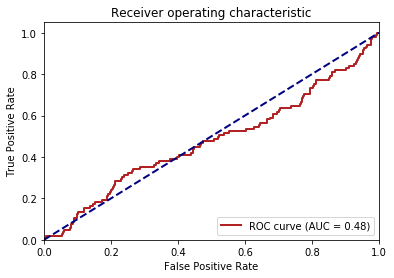

Average precision-recall score: 0.09


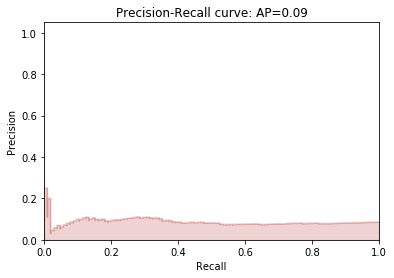

Best F1 score of  0.16363636363636364  achieved at threshold of  0.5265429248028788
Corresponding vales are: Precision  0.10746268656716418  Recall:  0.34285714285714286


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 432x288 with 0 Axes>

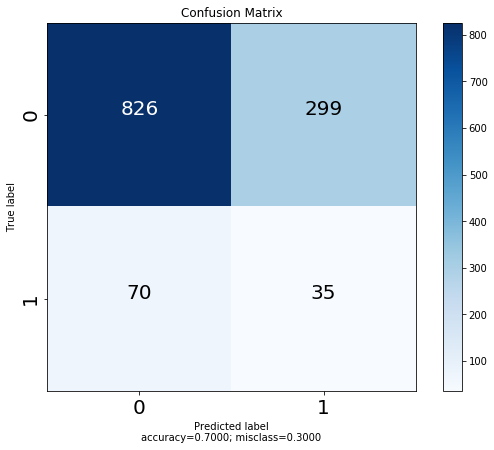

In [88]:
roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall = calc_metrics(y_gt_test, y_score_test, display_graphs=True)



np.save("Results/curves/"+grid_type+"/region_based_mult_gauss/fpr.npy", fpr)
np.save("Results/curves/"+grid_type+"/region_based_mult_gauss/tpr.npy", tpr)
np.save("Results/curves/"+grid_type+"/region_based_mult_gauss/precision.npy", precision)
np.save("Results/curves/"+grid_type+"/region_based_mult_gauss/recall.npy", recall)





In [398]:
threshold = 0.4
interval = 1

y_pred = [1 if e > threshold else 0 for e in scores]
pred_frameIds = []
pred_second_counts = []
for y,frameId,sec_count in zip(y_pred, Id_test, sec_count_test):
    if y==1:
        pred_frameIds.append(frameId)
        pred_second_counts.append(sec_count)
pred_frameIds.sort()
pred_second_counts.sort()


for i, second_count in enumerate(pred_second_counts):
    if second_count-pred_second_counts[max(i-1,0)] > interval:
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')

Anomaly detected at :  28  mins  4  seconds
Anomaly detected at :  28  mins  9  seconds
Anomaly detected at :  28  mins  18  seconds
Anomaly detected at :  28  mins  23  seconds
Anomaly detected at :  29  mins  4  seconds
Anomaly detected at :  29  mins  7  seconds
Anomaly detected at :  29  mins  9  seconds
Anomaly detected at :  29  mins  14  seconds
Anomaly detected at :  29  mins  16  seconds
Anomaly detected at :  29  mins  24  seconds
Anomaly detected at :  29  mins  27  seconds
Anomaly detected at :  29  mins  48  seconds
Anomaly detected at :  29  mins  50  seconds
Anomaly detected at :  29  mins  52  seconds
Anomaly detected at :  30  mins  0  seconds
Anomaly detected at :  30  mins  4  seconds
Anomaly detected at :  30  mins  11  seconds
Anomaly detected at :  30  mins  20  seconds
Anomaly detected at :  30  mins  26  seconds
Anomaly detected at :  30  mins  33  seconds
Anomaly detected at :  30  mins  48  seconds
Anomaly detected at :  30  mins  50  seconds
Anomaly detected 

### Autoencoder

In [89]:

region_w = 6
region_h = 6

In [90]:

region_scores = np.zeros((X_test.shape[0],int(ceil(X_train.shape[2]/region_h)),int(ceil(X_train.shape[3]/region_w))), dtype = np.float64)
region_scores.shape


(9838, 20, 1)

In [ ]:
for i in range(int(ceil(X_train.shape[3]/region_w))): # horizontal index
    for j in range(int(ceil(X_train.shape[2]/region_h))): # vertical index

        X_train_r = X_train[:,:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
        X_test_r = X_test[:,:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
        # print('(',region_h*j,'-',region_h*(j+1),')   (',region_w*i,'-',region_w*(i+1),')')
        
        X_train_r_flat = X_train_r.reshape((len(X_train_r), np.prod(X_train_r.shape[1:])))
        X_test_r_flat = X_test_r.reshape((len(X_test_r), np.prod(X_test_r.shape[1:])))
        
        ######################################################################
        
        input_dim = np.prod(X_train_r.shape[1:])
        encoding_dim = int(round(input_dim/2))

        # print(input_dim)

        input_layer = Input(shape=(input_dim, ))

        encoder = Dense(encoding_dim, activation="tanh", 
                        activity_regularizer=regularizers.l1(10e-5))(input_layer)
        encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

        decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
        decoder = Dense(input_dim, activation='relu')(decoder)

        autoencoder = Model(inputs=input_layer, outputs=decoder)
        
        nb_epoch = 10
        batch_size = 32

        autoencoder.compile(optimizer='adam', 
                            loss='mean_squared_error', 
                            metrics=['accuracy'])

        checkpointer = ModelCheckpoint(filepath="models/model_r.h5",
                                       verbose=0,
                                       save_best_only=True)


        history = autoencoder.fit(X_train_r_flat, X_train_r_flat,
                            epochs=nb_epoch,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=(X_test_r_flat, X_test_r_flat),
                            verbose=1,
                            callbacks=[checkpointer]).history
        
        autoencoder = load_model('models/model_r.h5')
        
        predictions = autoencoder.predict(X_test_r_flat)
        
        mse = np.mean(np.power(X_test_r_flat - predictions, 2), axis=1)
        error_df = pd.DataFrame({'reconstruction_error': mse})
        
        region_scores[:,j,i] = error_df.reconstruction_error.values




        

Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 8s 1ms/step - loss: 10.3825 - acc: 0.0204 - val_loss: 8.5564 - val_acc: 0.0189
Epoch 2/10
6559/6559 [==============================] - 7s 1ms/step - loss: 7.2322 - acc: 0.0387 - val_loss: 7.7234 - val_acc: 0.0327
Epoch 3/10
6559/6559 [==============================] - 6s 878us/step - loss: 6.6623 - acc: 0.0418 - val_loss: 7.8222 - val_acc: 0.0388
Epoch 4/10
6559/6559 [==============================] - 6s 873us/step - loss: 6.3129 - acc: 0.0514 - val_loss: 7.2728 - val_acc: 0.0478
Epoch 5/10
6559/6559 [==============================] - 6s 900us/step - loss: 6.1751 - acc: 0.0570 - val_loss: 7.3254 - val_acc: 0.0434
Epoch 6/10
6559/6559 [==============================] - 6s 885us/step - loss: 6.0857 - acc: 0.0617 - val_loss: 7.2130 - val_acc: 0.0456
Epoch 7/10
6559/6559 [==============================] - 6s 948us/step - loss: 5.9254 - acc: 0.0617 - val_loss: 7.0252 - val_acc: 0.0567
Epo

In [35]:
np.save("grid_arrays/region_scores_autoencoder.npy", region_scores)

In [36]:
region_scores = np.load("grid_arrays/region_scores_autoencoder.npy")

#### Average

In [37]:
scores = np.mean(region_scores, axis=(1,2))

y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])
    

ROC_AUC: 0.59


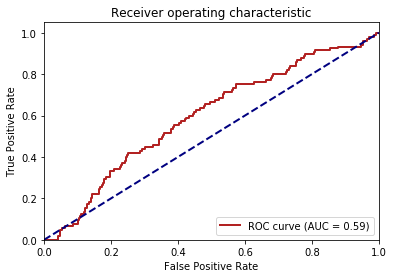

Average precision-recall score: 0.11


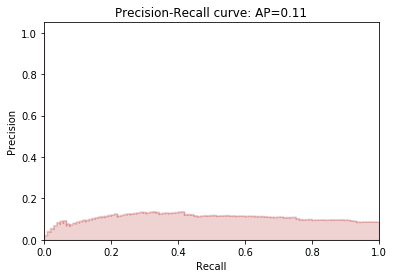

Best F1 score of  0.20465116279069767  achieved at threshold of  0.04356464233018899
Corresponding vales are: Precision  0.13538461538461538  Recall:  0.41904761904761906


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 432x288 with 0 Axes>

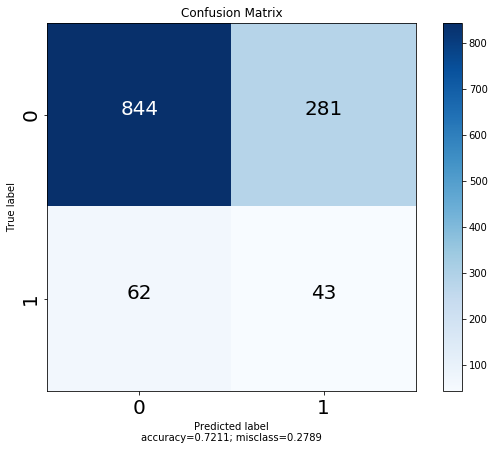

In [38]:
roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall = calc_metrics(y_gt_test, y_score_test, display_graphs=True)



np.save("Results/curves/"+grid_type+"/region_based_autoencoder_avg/fpr.npy", fpr)
np.save("Results/curves/"+grid_type+"/region_based_autoencoder_avg/tpr.npy", tpr)
np.save("Results/curves/"+grid_type+"/region_based_autoencoder_avg/precision.npy", precision)
np.save("Results/curves/"+grid_type+"/region_based_autoencoder_avg/recall.npy", recall)





#### Maximum

In [39]:
scores = np.amax(region_scores, axis=(1,2))

y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])
    

ROC_AUC: 0.60


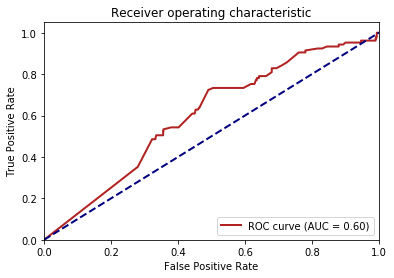

Average precision-recall score: 0.11


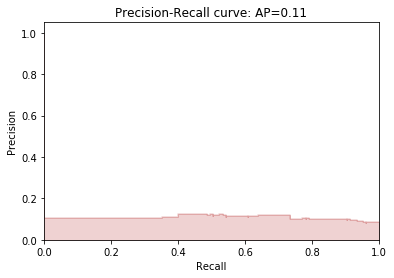

Best F1 score of  0.2073669849931787  achieved at threshold of  0.6667084693908691
Corresponding vales are: Precision  0.12101910828025478  Recall:  0.7238095238095238


<Figure size 432x288 with 0 Axes>

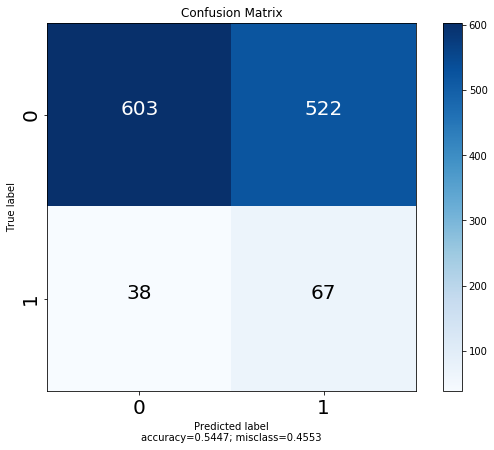

In [40]:
roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall = calc_metrics(y_gt_test, y_score_test, display_graphs=True)



np.save("Results/curves/"+grid_type+"/region_based_autoencoder_max/fpr.npy", fpr)
np.save("Results/curves/"+grid_type+"/region_based_autoencoder_max/tpr.npy", tpr)
np.save("Results/curves/"+grid_type+"/region_based_autoencoder_max/precision.npy", precision)
np.save("Results/curves/"+grid_type+"/region_based_autoencoder_max/recall.npy", recall)





#### Variance in Error

In [41]:
print(region_scores.shape)
mean_reg_score = np.amax(region_scores, axis=0)
print(mean_reg_score.shape)

y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)


scores = np.zeros((X_test.shape[0]), dtype = np.float64)


for i, (reg_score,frameId,second_count)   in enumerate(zip(region_scores,Id_test,sec_count_test)):
    reg_score_numeric = np.array(reg_score, dtype = np.float64)
    var_arr = np.subtract(mean_reg_score,reg_score_numeric)
    #print(var_arr)
    #if 0 in var_arr:
        #print('Found 0')
    #var_arr = np.divide(1,var_arr)
    #if len(var_arr[np.isinf(var_arr)]) > 0:
        #print('some elements')
    #var = distance.sqeuclidean(np.ravel(reg_score_numeric),np.ravel(mean_reg_score))
    #print(np.amax(var_arr))
    scores[i] = np.amax(var_arr)
    
#print(scores)
#scores = np.divide(1,scores)
#print(scores)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])
    

(9838, 12, 20)
(12, 20)


ROC_AUC: 0.50


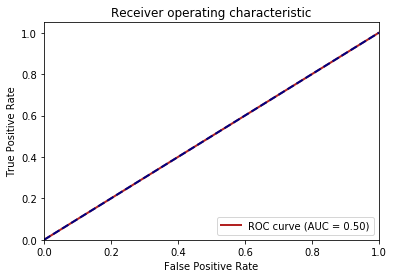

Average precision-recall score: 0.09


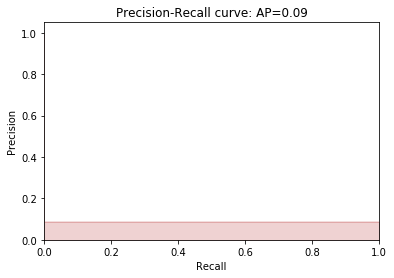

Best F1 score of  0.15730337078651685  achieved at threshold of  1.0
Corresponding vales are: Precision  0.08536585365853659  Recall:  1.0


<Figure size 432x288 with 0 Axes>

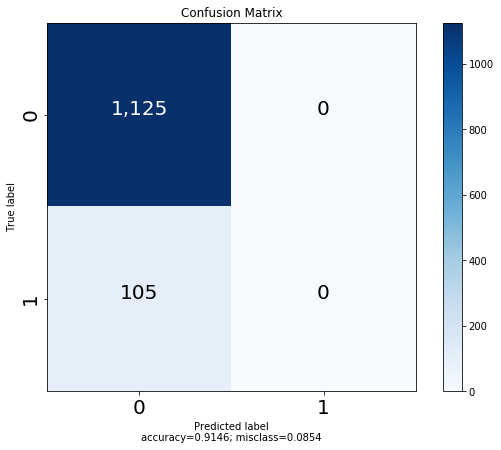

In [42]:
roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall = calc_metrics(y_gt_test, y_score_test, display_graphs=True)


np.save("Results/curves/"+grid_type+"/region_based_autoencoder_var_error/fpr.npy", fpr)
np.save("Results/curves/"+grid_type+"/region_based_autoencoder_var_error/tpr.npy", tpr)
np.save("Results/curves/"+grid_type+"/region_based_autoencoder_var_error/precision.npy", precision)
np.save("Results/curves/"+grid_type+"/region_based_autoencoder_var_error/recall.npy", recall)



